In [1]:
import os, subprocess
print("JAVA_HOME =", os.environ.get("JAVA_HOME"))
print("java -version output:")
print(subprocess.run(["java", "-version"], capture_output=True, text=True).stderr)


JAVA_HOME = None
java -version output:
openjdk version "17.0.16" 2025-07-15
OpenJDK Runtime Environment Homebrew (build 17.0.16+0)
OpenJDK 64-Bit Server VM Homebrew (build 17.0.16+0, mixed mode, sharing)



In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("test").getOrCreate()
print(spark.version)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/10/17 06:56:11 WARN Utils: Your hostname, Erikas-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 10.0.0.91 instead (on interface en0)
25/10/17 06:56:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/17 06:56:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


4.0.1


In [3]:
# Core libraries
import os
import warnings
import json
warnings.filterwarnings('ignore')

# Data processing
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, avg, sum, count, min, max, stddev, percentile_approx,
    lag, lead, datediff, date_format, hour, dayofweek, weekofyear,
    when, lit, expr, window, rank, row_number, monotonically_increasing_id
)
from pyspark.sql.window import Window
from pyspark.sql.types import *

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical analysis
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.options.display.float_format = '{:.2f}'.format

print("✅ Libraries imported successfully")


✅ Libraries imported successfully


In [4]:
# Initialize Spark Session with optimized configurations
spark = SparkSession.builder \
    .appName("Ethereum Blockchain Analytics") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")
print(f"Spark {spark.version} initialized")
print(f" Spark UI: {spark.sparkContext.uiWebUrl}")


Spark 4.0.1 initialized
 Spark UI: http://10.0.0.91:4040


25/10/17 06:56:22 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [5]:
## 2️⃣ Data Ingestion from Athena Results
def download_csv_from_s3(s3_bucket, s3_prefix, csv_files_to_download):
    """
    Download CSV files from S3 bucket to local directory.
    
    Args:
        s3_bucket: S3 bucket name (e.g., 'athena-erika')
        s3_prefix: S3 prefix/folder (e.g., 'data/results')
        csv_files_to_download: List of CSV filenames to download
    
    Returns:
        Dictionary mapping dataset names to local file paths
    """
    import subprocess
    
    print("\n🔽 DOWNLOADING CSV FILES FROM S3")
    print("=" * 70)
    print(f"S3 Bucket: s3://{s3_bucket}/{s3_prefix}/")
    print(f"Files to download: {len(csv_files_to_download)}")
    print("=" * 70)
    
    # Create local data directory
    local_data_dir = "blockchain_data"
    os.makedirs(local_data_dir, exist_ok=True)
    
    downloaded_files = {}
    total_size = 0
    
    for csv_file in csv_files_to_download:
        s3_path = f"s3://{s3_bucket}/{s3_prefix}/{csv_file}"
        local_path = os.path.join(local_data_dir, csv_file)
        
        print(f"\n📥 Downloading: {csv_file}")
        
        try:
            # Check if file already exists locally
            if os.path.exists(local_path):
                file_size = os.path.getsize(local_path)
                print(f"   ✅ Already exists locally: {file_size/1024:.1f} KB")
                downloaded_files[csv_file] = local_path
                total_size += file_size
                continue
            
            # Download from S3 using AWS CLI
            result = subprocess.run([
                "aws", "s3", "cp", s3_path, local_path
            ], capture_output=True, text=True, timeout=300)
            
            if result.returncode == 0:
                file_size = os.path.getsize(local_path)
                print(f"   ✅ Downloaded: {file_size/1024:.1f} KB")
                downloaded_files[csv_file] = local_path
                total_size += file_size
            else:
                print(f"   ⚠️  Failed to download: {result.stderr}")
                
        except subprocess.TimeoutExpired:
            print(f"   ❌ Download timeout for {csv_file}")
        except Exception as e:
            print(f"   ❌ Error: {str(e)}")
    
    print("\n" + "=" * 70)
    print(f"✅ Download Complete: {len(downloaded_files)}/{len(csv_files_to_download)} files")
    print(f"📊 Total size: {total_size/1024/1024:.2f} MB")
    print("=" * 70)
    
    return downloaded_files


In [6]:
# S3 Configuration (from your athena_blockchain.py)
S3_BUCKET = "athena-erika"
S3_PREFIX = "data/results"

# Define CSV files to download
csv_files_list = [
    'network_overview.csv',
    'daily_network_activity_last30days.csv',
    'gas_price_analysis_last7days.csv',
    'top_whale_wallets_last7days.csv',
    'contract_deployment_trends_last30days.csv',
    'top_contract_deployers_last30days.csv',
    'top_token_transfers_last7days.csv',
    'tx_success_analysis_last30days.csv',
    'expensive_failed_txs_last7days.csv',
    'top_block_producers_last7days.csv',
    'network_congestion_patterns_last7days.csv',
    'top_contracts_by_interaction_last30days.csv'
]

# Download files from S3
downloaded_paths = download_csv_from_s3(S3_BUCKET, S3_PREFIX, csv_files_list)
print(downloaded_paths)


🔽 DOWNLOADING CSV FILES FROM S3
S3 Bucket: s3://athena-erika/data/results/
Files to download: 12

📥 Downloading: network_overview.csv
   ✅ Already exists locally: 0.1 KB

📥 Downloading: daily_network_activity_last30days.csv
   ✅ Already exists locally: 1.4 KB

📥 Downloading: gas_price_analysis_last7days.csv
   ✅ Already exists locally: 0.9 KB

📥 Downloading: top_whale_wallets_last7days.csv
   ✅ Already exists locally: 2.2 KB

📥 Downloading: contract_deployment_trends_last30days.csv
   ✅ Already exists locally: 2.2 KB

📥 Downloading: top_contract_deployers_last30days.csv
   ✅ Already exists locally: 0.9 KB

📥 Downloading: top_token_transfers_last7days.csv
   ✅ Already exists locally: 2.0 KB

📥 Downloading: tx_success_analysis_last30days.csv
   ✅ Already exists locally: 2.1 KB

📥 Downloading: expensive_failed_txs_last7days.csv
   ✅ Already exists locally: 0.7 KB

📥 Downloading: top_block_producers_last7days.csv
   ✅ Already exists locally: 1.5 KB

📥 Downloading: network_congestion_patte

In [7]:
# Map friendly names to downloaded files
dataset_mapping = {
    'network_overview': 'network_overview.csv',
    'daily_activity': 'daily_network_activity_last30days.csv',
    'gas_analysis': 'gas_price_analysis_last7days.csv',
    'whale_wallets': 'top_whale_wallets_last7days.csv',
    'contract_deployments': 'contract_deployment_trends_last30days.csv',
    'contract_deployers': 'top_contract_deployers_last30days.csv',
    'token_transfers': 'top_token_transfers_last7days.csv',
    'tx_success': 'tx_success_analysis_last30days.csv',
    'failed_txs': 'expensive_failed_txs_last7days.csv',
    'block_producers': 'top_block_producers_last7days.csv',
    'congestion': 'network_congestion_patterns_last7days.csv',
    'top_contracts': 'top_contracts_by_interaction_last30days.csv'
}

# Load datasets into Spark DataFrames
print("\n📊 LOADING DATASETS INTO SPARK")
print("=" * 70)

spark_dfs = {}
for name, csv_file in dataset_mapping.items():
    if csv_file in downloaded_paths:
        local_path = downloaded_paths[csv_file]
        try:
            spark_dfs[name] = spark.read.csv(local_path, header=True, inferSchema=True)
            row_count = spark_dfs[name].count()
            print(f"✅ {name:25} -> {row_count:>6} rows")
        except Exception as e:
            print(f"❌ {name:25} -> Error: {str(e)}")
    else:
        print(f"⚠️  {name:25} -> File not downloaded")

print("=" * 70)
print(f"✅ Loaded {len(spark_dfs)} datasets successfully")
print("=" * 70)



📊 LOADING DATASETS INTO SPARK
✅ network_overview          ->      1 rows
✅ daily_activity            ->     29 rows
✅ gas_analysis              ->      6 rows
✅ whale_wallets             ->     20 rows
✅ contract_deployments      ->     20 rows
✅ contract_deployers        ->     10 rows
✅ token_transfers           ->     20 rows
✅ tx_success                ->     29 rows
✅ failed_txs                ->      3 rows
✅ block_producers           ->     15 rows
✅ congestion                ->     24 rows
✅ top_contracts             ->     20 rows
✅ Loaded 12 datasets successfully


## 3- Network Health Analysis
### Time Series Analysis of Ethereum Network Activity


In [8]:
# Convert to Pandas for time series visualization
if 'daily_activity' in spark_dfs:
    df_daily = spark_dfs['daily_activity'].toPandas()
    df_daily['date'] = pd.to_datetime(df_daily['date'])
    df_daily = df_daily.sort_values('date')
    
    print("Daily Network Activity Statistics:")
    print(df_daily.describe())
    
    # Calculate growth metrics
    df_daily['tx_growth'] = df_daily['total_transactions'].pct_change() * 100
    df_daily['block_growth'] = df_daily['total_blocks'].pct_change() * 100

Daily Network Activity Statistics:
                      date  total_blocks  total_transactions  avg_gas_used  \
count                   29         29.00               29.00         29.00   
mean   2025-09-25 00:00:00       7155.59          1623157.45   22720803.28   
min    2025-09-11 00:00:00       7140.00          1387207.00   22669705.00   
25%    2025-09-18 00:00:00       7150.00          1588927.00   22696444.00   
50%    2025-09-25 00:00:00       7155.00          1634980.00   22719039.00   
75%    2025-10-02 00:00:00       7161.00          1704159.00   22727040.00   
max    2025-10-09 00:00:00       7171.00          1843631.00   22816913.00   
std                    NaN          8.22           125287.93      36510.64   

       avg_block_utilization_pct  total_data_mb  
count                      29.00          29.00  
mean                       50.51         848.97  
min                        50.39         744.00  
25%                        50.45         842.00  
50%         

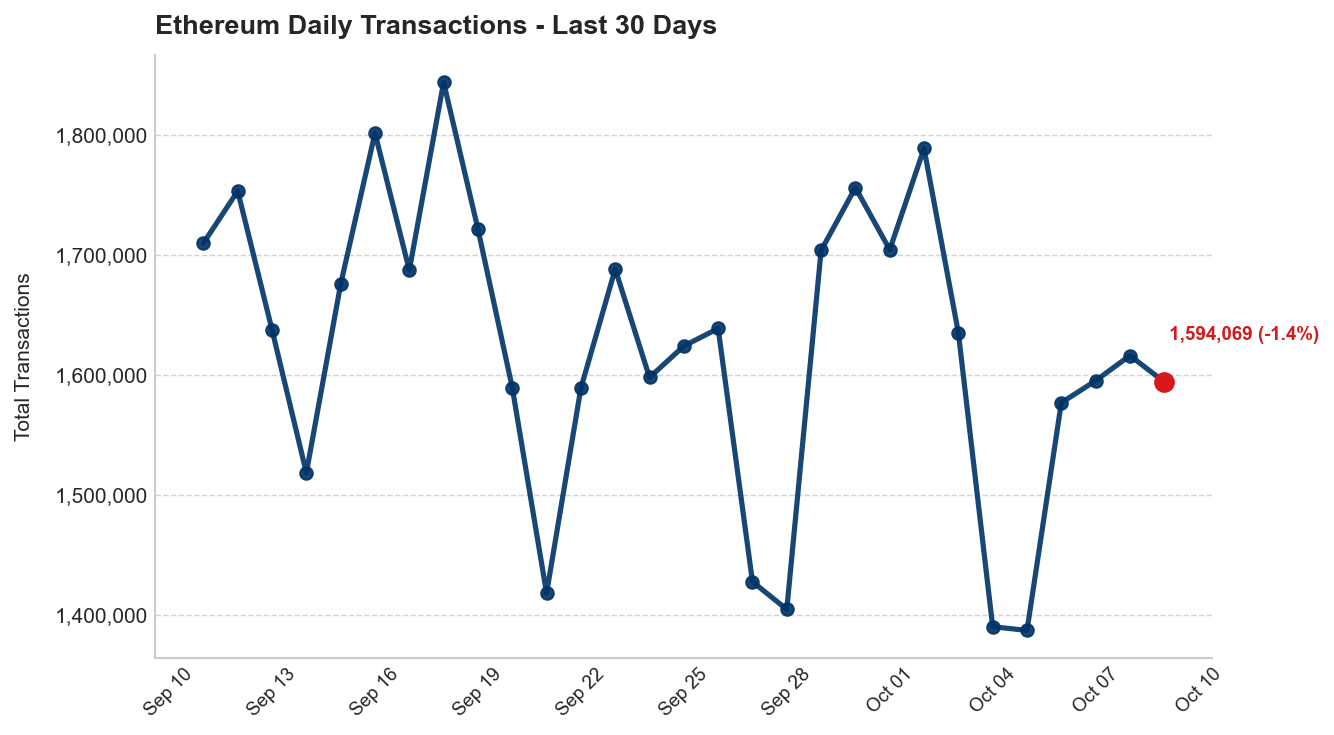

In [9]:
if 'daily_activity' in spark_dfs:
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(9, 5), dpi=150)

    # Plot
    ax.plot(
        df_daily['date'],
        df_daily['total_transactions'],
        color='#003366',        
        marker='o',
        markersize=6,
        linewidth=2.5,
        alpha=0.9
    )

    # Highlight the most recent value
    ax.scatter(df_daily['date'].iloc[-1],
            df_daily['total_transactions'].iloc[-1],
            color='#D7191C', s=80, zorder=5)

    # Remove clutter
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, axis='y', color='lightgray', linestyle='--', linewidth=0.7)
    ax.grid(False, axis='x')

    # Format x-axis
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.xticks(rotation=45, fontsize=9)

    # Format y-axis with commas and remove scientific notation
    ax.ticklabel_format(style='plain', axis='y')
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))

    # Title and labels
    plt.title("Ethereum Daily Transactions - Last 30 Days", fontsize=13, fontweight='bold', loc='left', pad=10)
    plt.xlabel("")
    plt.ylabel("Total Transactions", fontsize=10, labelpad=10)

    # Annotate insight
    latest_val = df_daily['total_transactions'].iloc[-1]
    prev_val = df_daily['total_transactions'].iloc[-2]
    delta = (latest_val - prev_val) / prev_val * 100

    ax.text(
        df_daily['date'].iloc[-1],
        latest_val * 1.02,
        f" {latest_val:,.0f} ({delta:+.1f}%)",
        va='bottom',
        ha='left',
        fontsize=9,
        color='#D7191C' if delta < 0 else '#1A9850',
        fontweight='bold'
    )

    # Final polish
    plt.tight_layout()
    plt.savefig("Ethereum Daily Transactions - Last 30 Days.png", dpi=300)
    plt.show()


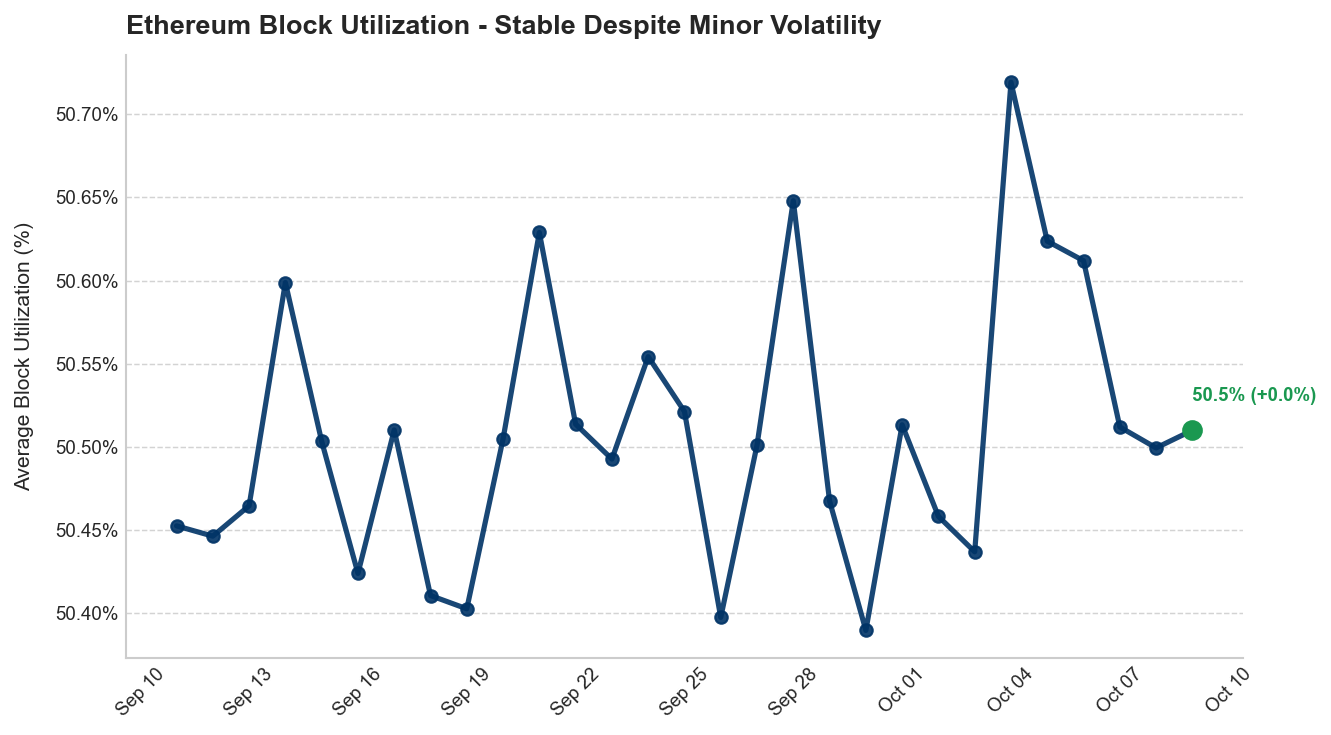

In [10]:
if 'daily_activity' in spark_dfs:
    # --- Visual identity (clean white background) ---
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(9, 5), dpi=150)
    fig.patch.set_facecolor('white')   # ensure full white canvas
    ax.set_facecolor('white')          # ensure white plot area

    # --- Main line ---
    ax.plot(
        df_daily['date'],
        df_daily['avg_block_utilization_pct'],
        color='#003366',           
        marker='o',
        markersize=6,
        linewidth=2.5,
        alpha=0.9
    )

    # --- Highlight most recent value ---
    ax.scatter(
        df_daily['date'].iloc[-1],
        df_daily['avg_block_utilization_pct'].iloc[-1],
        color='#1A9850', s=80, zorder=5
    )

    # --- Compute & annotate delta ---
    latest_val = df_daily['avg_block_utilization_pct'].iloc[-1]
    prev_val = df_daily['avg_block_utilization_pct'].iloc[-2]
    delta = (latest_val - prev_val) / prev_val * 100

    ax.text(
        df_daily['date'].iloc[-1],
        latest_val * 1.0003,  # small lift above marker
        f"{latest_val:.1f}% ({delta:+.1f}%)",
        va='bottom',
        ha='left',
        fontsize=9,
        color='#D7191C' if delta < 0 else '#1A9850',
        fontweight='bold'
    )

    # --- Minimalist formatting ---
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, axis='y', color='lightgray', linestyle='--', linewidth=0.7)
    ax.grid(False, axis='x')

    # --- Axis formatting ---
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}%"))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.xticks(rotation=45, fontsize=9)
    plt.yticks(fontsize=9)

    # --- Titles & labels ---
    plt.title(
        "Ethereum Block Utilization - Stable Despite Minor Volatility",
        fontsize=13,
        fontweight='bold',
        loc='left',
        pad=10
    )
    plt.xlabel("")
    plt.ylabel("Average Block Utilization (%)", fontsize=10, labelpad=10)

    # --- Final layout ---
    plt.tight_layout()
    plt.savefig("Ethereum Block Utilization - Stable Despite Minor Volatility.png", dpi=300)
    plt.show()



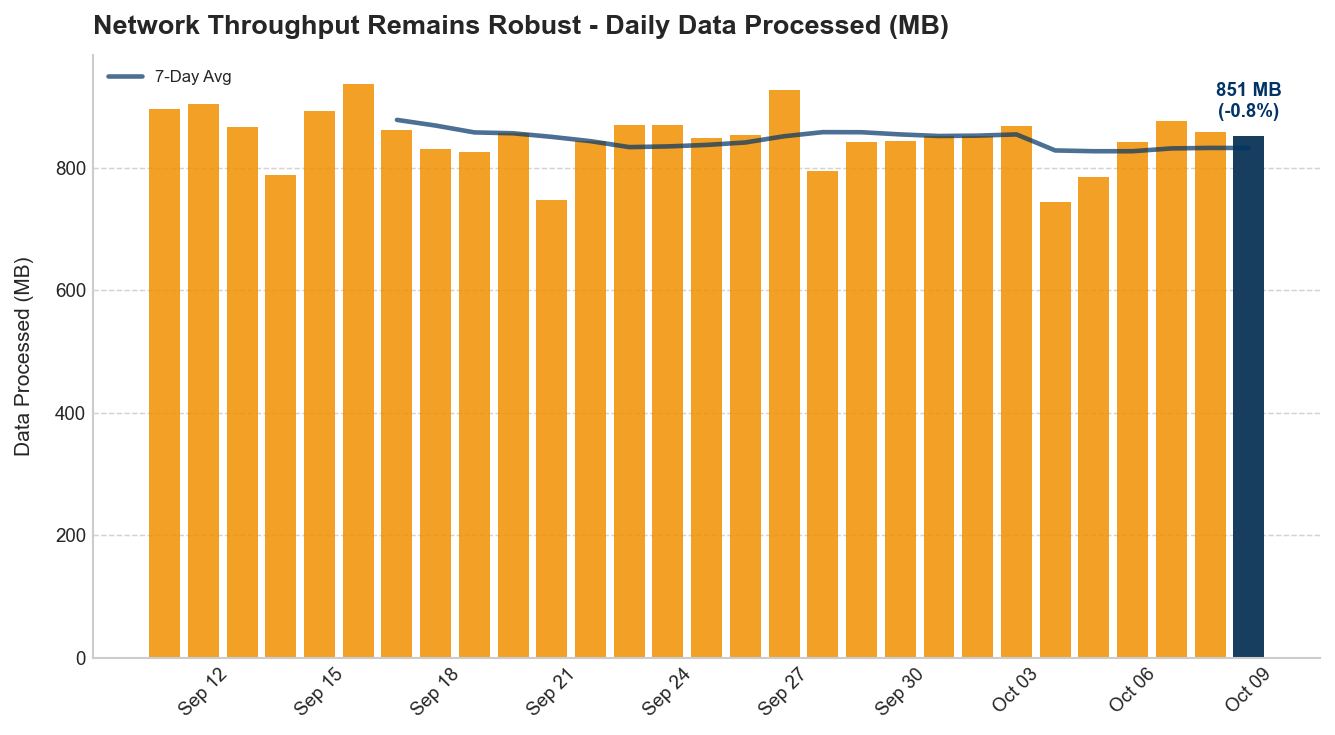

In [11]:
if 'daily_activity' in spark_dfs:
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(9, 5), dpi=150)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # --- Plot bars ---
    ax.bar(
        df_daily['date'],
        df_daily['total_data_mb'],
        color='#F18F01',          
        alpha=0.85,
        edgecolor='none',
        width=0.8
    )

    # --- Highlight the most recent bar ---
    ax.bar(
        df_daily['date'].iloc[-1],
        df_daily['total_data_mb'].iloc[-1],
        color='#003366',          
        alpha=0.9
    )

    # --- Compute and annotate delta ---
    latest_val = df_daily['total_data_mb'].iloc[-1]
    prev_val = df_daily['total_data_mb'].iloc[-2]
    delta = (latest_val - prev_val) / prev_val * 100

    ax.text(
        df_daily['date'].iloc[-1],
        latest_val * 1.03,  # position above bar
        f"{latest_val:,.0f} MB\n({delta:+.1f}%)",
        ha='center',
        va='bottom',
        fontsize=9,
        color='#003366',
        fontweight='bold'
    )

    # --- Minimalist chart cleanup ---
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, axis='y', color='lightgray', linestyle='--', linewidth=0.7)
    ax.grid(False, axis='x')

    # --- Axis formatting ---
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.xticks(rotation=45, fontsize=9)
    plt.yticks(fontsize=9)

    # --- Insight-driven title ---
    plt.title(
        "Network Throughput Remains Robust - Daily Data Processed (MB)",
        fontsize=13,
        fontweight='bold',
        loc='left',
        pad=10
    )
    plt.xlabel("")
    plt.ylabel("Data Processed (MB)", fontsize=10, labelpad=10)

    # --- Optional 7-day average trendline for context ---
    df_daily_sorted = df_daily.sort_values('date')
    rolling_avg = df_daily_sorted['total_data_mb'].rolling(window=7).mean()
    ax.plot(df_daily_sorted['date'], rolling_avg, color='#003366', linewidth=2.2, alpha=0.7, label='7-Day Avg')

    # Add legend inline (consulting-style, top-right, small font)
    ax.legend(frameon=False, loc='upper left', fontsize=8)

    # --- Final layout and export ---
    plt.tight_layout()
    plt.savefig("Network Throughput Remains Robust - Daily Data Processed (MB).png", dpi=300)
    plt.show()


## 4- Gas Economics Deep Dive
### Statistical Analysis of Gas Prices and Fee Distribution

In [12]:
if 'gas_analysis' in spark_dfs:
    df_gas = spark_dfs['gas_analysis'].toPandas()
    df_gas['date'] = pd.to_datetime(df_gas['date'])
    df_gas = df_gas.sort_values('date')
    
    # Calculate volatility metrics
    df_gas['gas_volatility'] = df_gas['avg_gas_price_gwei'].rolling(window=3).std()
    df_gas['median_to_avg_ratio'] = df_gas['median_gas_price_gwei'] / df_gas['avg_gas_price_gwei']
    
    print("\n📊 Gas Price Statistics:")
    print(df_gas[['avg_gas_price_gwei', 'median_gas_price_gwei', 'p95_gas_price_gwei']].describe())
    #save in json 
    df_gas[['avg_gas_price_gwei', 'median_gas_price_gwei', 'p95_gas_price_gwei']].describe().to_json("gas_price_statistics.json")


📊 Gas Price Statistics:
       avg_gas_price_gwei  median_gas_price_gwei  p95_gas_price_gwei
count                6.00                   6.00                6.00
mean                 1.34                   0.68                3.31
std                  0.39                   0.36                1.23
min                  0.88                   0.24                2.18
25%                  1.03                   0.37                2.31
50%                  1.31                   0.72                2.92
75%                  1.66                   0.94                4.40
max                  1.81                   1.12                4.84


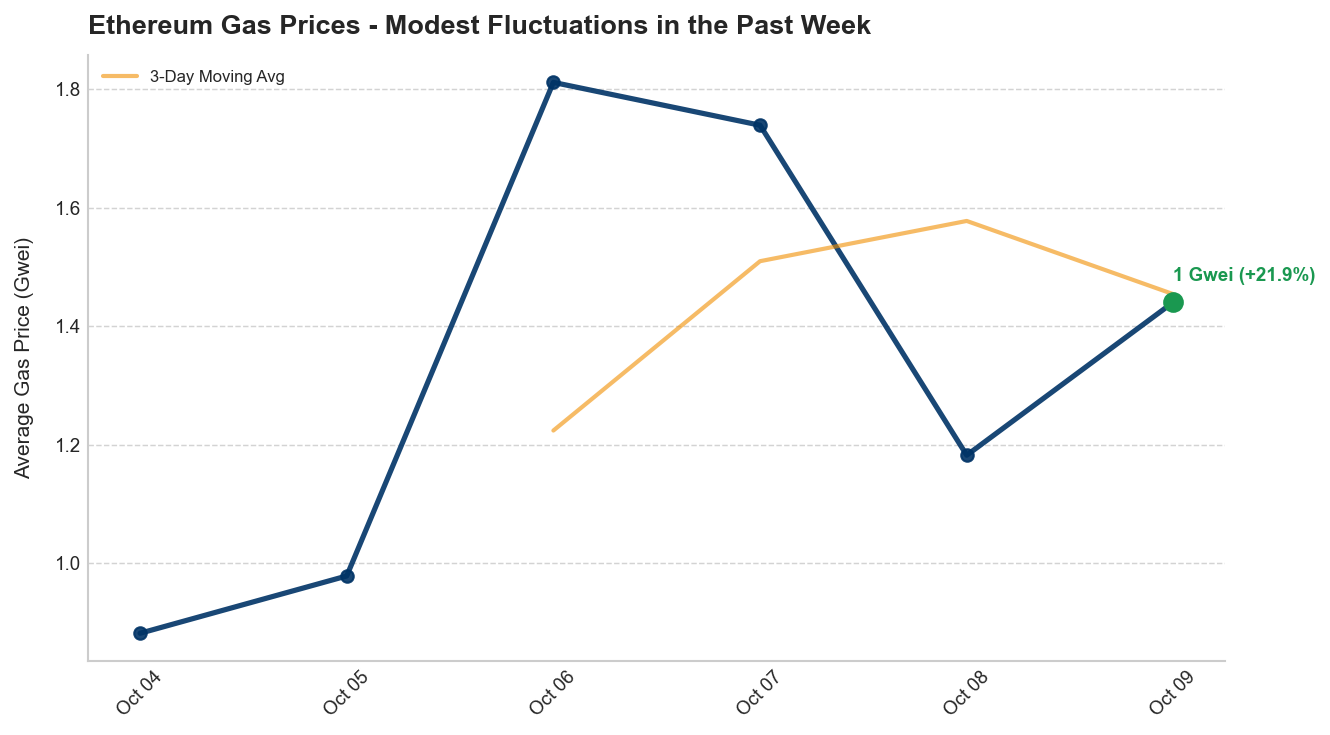

In [13]:
if 'gas_analysis' in spark_dfs:
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(9, 5), dpi=150)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # --- Plot line ---
    ax.plot(
        df_gas['date'],
        df_gas['avg_gas_price_gwei'],
        color='#003366',        
        linewidth=2.5,
        marker='o',
        markersize=6,
        alpha=0.9
    )

    # --- Highlight latest point ---
    ax.scatter(
        df_gas['date'].iloc[-1],
        df_gas['avg_gas_price_gwei'].iloc[-1],
        color='#1A9850', s=80, zorder=5
    )

    # --- Compute latest delta ---
    latest_val = df_gas['avg_gas_price_gwei'].iloc[-1]
    prev_val = df_gas['avg_gas_price_gwei'].iloc[-2]
    delta = (latest_val - prev_val) / prev_val * 100

    # --- Add concise annotation above last point ---
    ax.text(
        df_gas['date'].iloc[-1],
        latest_val * 1.02,  # lift slightly above
        f"{latest_val:,.0f} Gwei ({delta:+.1f}%)",
        va='bottom',
        ha='left',
        fontsize=9,
        color='#D7191C' if delta < 0 else '#1A9850',
        fontweight='bold'
    )

    # --- Minimalist consulting cleanup ---
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, axis='y', color='lightgray', linestyle='--', linewidth=0.7)
    ax.grid(False, axis='x')

    # --- Format X/Y axes ---
    ax.ticklabel_format(style='plain', axis='y')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.xticks(rotation=45, fontsize=9)
    plt.yticks(fontsize=9)

    # --- Title & labels (insight-driven) ---
    plt.title(
        "Ethereum Gas Prices - Modest Fluctuations in the Past Week",
        fontsize=13,
        fontweight='bold',
        loc='left',
        pad=10
    )
    plt.xlabel("")
    plt.ylabel("Average Gas Price (Gwei)", fontsize=10, labelpad=10)

    # --- Optional 3-day moving average for smoother trend ---
    df_gas_sorted = df_gas.sort_values('date')
    rolling_avg = df_gas_sorted['avg_gas_price_gwei'].rolling(window=3).mean()
    ax.plot(df_gas_sorted['date'], rolling_avg, color='#F18F01', linewidth=2, alpha=0.6, label='3-Day Moving Avg')

    # --- Inline legend for context ---
    ax.legend(frameon=False, loc='upper left', fontsize=8)

    # --- Final layout ---
    plt.tight_layout()
    plt.savefig("Ethereum Gas Prices - Modest Fluctuations in the Past Week.png", dpi=300, bbox_inches='tight', transparent=False)
    plt.show()


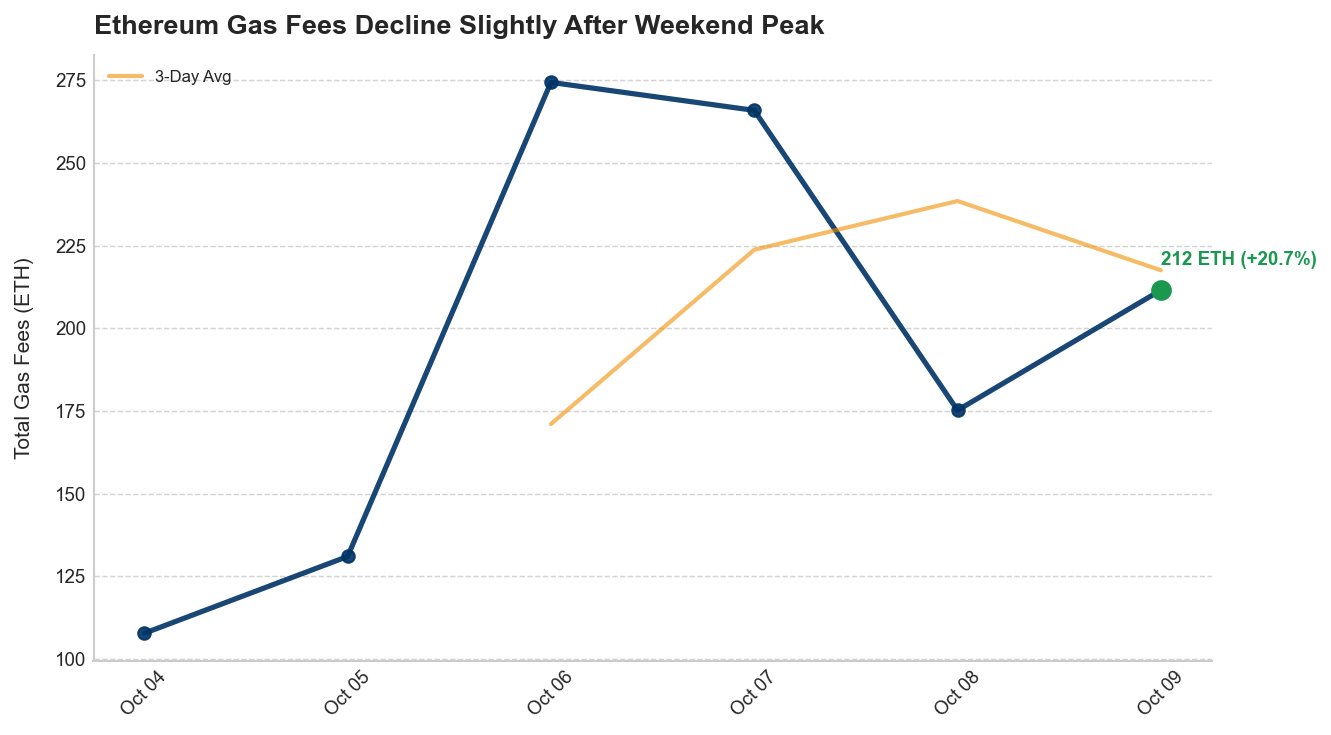

In [14]:
if 'gas_analysis' in spark_dfs:
    # --- Base style ---
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(9, 5), dpi=150)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # --- Main line ---
    ax.plot(
        df_gas['date'],
        df_gas['total_fees_eth'],
        color='#003366',        
        linewidth=2.5,
        marker='o',
        markersize=6,
        alpha=0.9
    )

    # --- Highlight latest point ---
    ax.scatter(
        df_gas['date'].iloc[-1],
        df_gas['total_fees_eth'].iloc[-1],
        color='#1A9850', s=80, zorder=5
    )

    # --- Compute delta ---
    latest_val = df_gas['total_fees_eth'].iloc[-1]
    prev_val = df_gas['total_fees_eth'].iloc[-2]
    delta = (latest_val - prev_val) / prev_val * 100

    # --- Inline annotation above last point ---
    ax.text(
        df_gas['date'].iloc[-1],
        latest_val * 1.03,  # slightly above
        f"{latest_val:,.0f} ETH ({delta:+.1f}%)",
        va='bottom',
        ha='left',
        fontsize=9,
        color='#D7191C' if delta < 0 else '#1A9850',
        fontweight='bold'
    )

    # --- Minimalist grid and axes ---
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, axis='y', color='lightgray', linestyle='--', linewidth=0.7)
    ax.grid(False, axis='x')

    # --- Format X and Y axes ---
    ax.ticklabel_format(style='plain', axis='y')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.xticks(rotation=45, fontsize=9)
    plt.yticks(fontsize=9)

    # --- Insight-based title ---
    plt.title(
        "Ethereum Gas Fees Decline Slightly After Weekend Peak",
        fontsize=13,
        fontweight='bold',
        loc='left',
        pad=10
    )
    plt.xlabel("")
    plt.ylabel("Total Gas Fees (ETH)", fontsize=10, labelpad=10)

    # --- Optional: 3-day moving average for smoother view ---
    df_gas_sorted = df_gas.sort_values('date')
    rolling_avg = df_gas_sorted['total_fees_eth'].rolling(window=3).mean()
    ax.plot(df_gas_sorted['date'], rolling_avg, color='#F18F01', linewidth=2, alpha=0.6, label='3-Day Avg')

    # --- Inline legend ---
    ax.legend(frameon=False, loc='upper left', fontsize=8)

    # --- Final touches ---
    plt.tight_layout()
    plt.savefig("Ethereum Gas Fees Decline Slightly After Weekend Peak.png", dpi=300, bbox_inches='tight', transparent=False)
    plt.show()


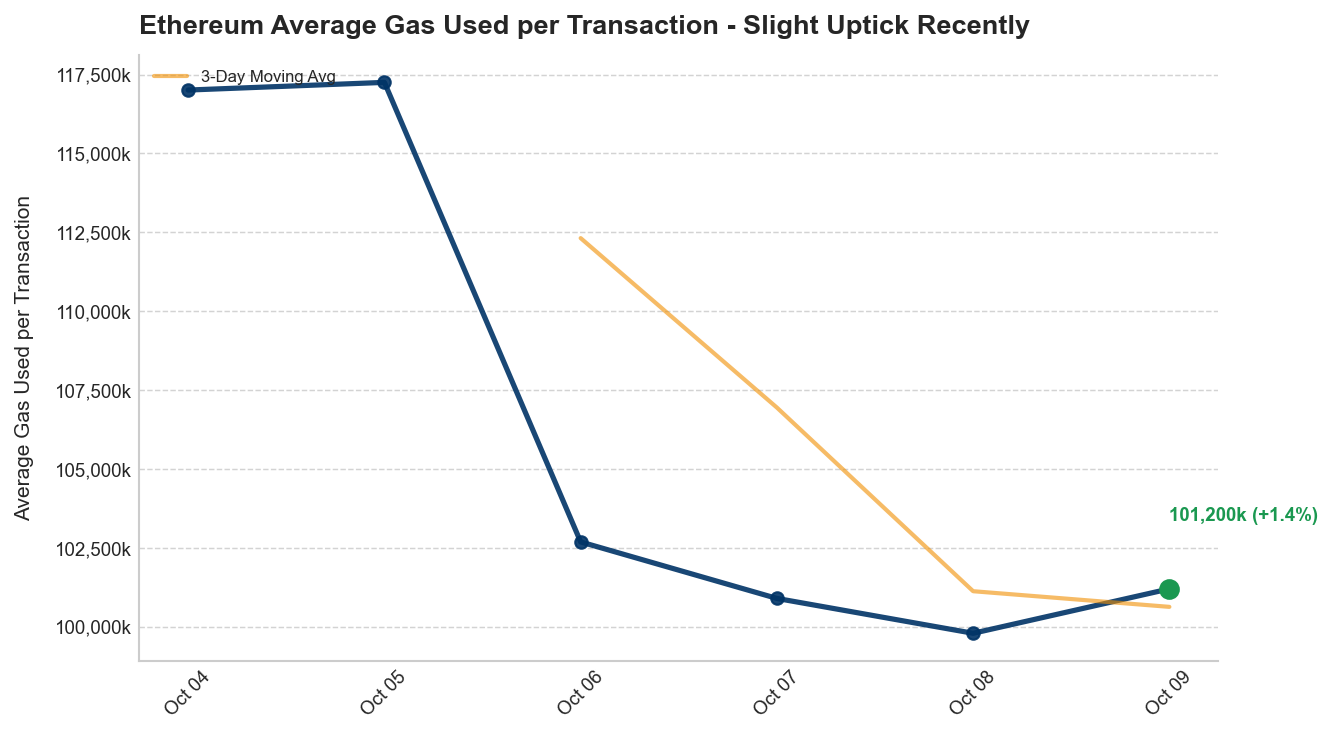

In [15]:
if 'gas_analysis' in spark_dfs:
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(9, 5), dpi=150)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # --- Plot line ---
    ax.plot(
        df_gas['date'],
        df_gas['avg_gas_per_tx'],
        color='#003366',        
        linewidth=2.5,
        marker='o',
        markersize=6,
        alpha=0.9
    )

    # --- Highlight latest point ---
    ax.scatter(
        df_gas['date'].iloc[-1],
        df_gas['avg_gas_per_tx'].iloc[-1],
        color='#1A9850', s=80, zorder=5
    )
    # --- Compute latest delta ---
    latest_val = df_gas['avg_gas_per_tx'].iloc[-1]
    prev_val = df_gas['avg_gas_per_tx'].iloc[-2]
    delta = (latest_val - prev_val) / prev_val * 100    
    # --- Add concise annotation above last point ---
    ax.text(
        df_gas['date'].iloc[-1],
        latest_val * 1.02,  # lift slightly above
        f"{latest_val:,.0f}k ({delta:+.1f}%)",
        va='bottom',
        ha='left',
        fontsize=9,
        color='#D7191C' if delta < 0 else '#1A9850',
        fontweight='bold'
    )
    # --- Minimalist consulting cleanup ---
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, axis='y', color='lightgray', linestyle='--', linewidth=0.7)
    ax.grid(False, axis='x')    
    # --- Format X/Y axes ---
    ax.ticklabel_format(style='plain', axis='y')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}k"))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.xticks(rotation=45, fontsize=9)
    plt.yticks(fontsize=9)
    # --- Title & labels (insight-driven) ---
    plt.title(
        "Ethereum Average Gas Used per Transaction - Slight Uptick Recently",
        fontsize=13,
        fontweight='bold',
        loc='left',
        pad=10
    )
    plt.xlabel("")
    plt.ylabel("Average Gas Used per Transaction", fontsize=10, labelpad=10)        
    # --- Optional 3-day moving average for smoother trend ---
    df_gas_sorted = df_gas.sort_values('date')
    rolling_avg = df_gas_sorted['avg_gas_per_tx'].rolling(window=3).mean()
    ax.plot(df_gas_sorted['date'], rolling_avg, color='#F18F01', linewidth=2, alpha=0.6, label='3-Day Moving Avg')
    # --- Inline legend for context ---
    ax.legend(frameon=False, loc='upper left', fontsize=8)
    # --- Final layout ---
    plt.tight_layout()
    plt.savefig("Ethereum Average Gas Used per Transaction.png", dpi=300, bbox_inches='tight', transparent=False)
    plt.show()  

## 5-  Whale Wallet Analysis
### Power Law Distribution and Wealth Concentration

In [16]:
if 'whale_wallets' in spark_dfs:
    df_whales = spark_dfs['whale_wallets'].toPandas()
    
    # Calculate concentration metrics
    total_eth_moved = df_whales['total_eth_sent'].sum()
    df_whales['market_share'] = (df_whales['total_eth_sent'] / total_eth_moved) * 100
    df_whales['cumulative_share'] = df_whales['market_share'].cumsum()
    
    # Gini coefficient for wealth concentration
    sorted_eth = df_whales['total_eth_sent'].sort_values()
    cumsum = sorted_eth.cumsum()
    gini = (2 * cumsum.sum() / (len(sorted_eth) * sorted_eth.sum())) - (len(sorted_eth) + 1) / len(sorted_eth)
    
    print(f"\nWhale Analytics:")
    print(f"Total ETH moved by top 20 wallets: {total_eth_moved:,.2f} ETH")
    print(f"Gini Coefficient (wealth concentration): {gini:.4f}")
    print(f"Top 5 wallets control: {df_whales.head(5)['market_share'].sum():.2f}% of volume")
    # save in json
    whale_stats = {
        "total_eth_moved": total_eth_moved,
        "gini_coefficient": gini,
        "top_5_wallets_market_share": df_whales.head(5)['market_share'].sum()
    }
    with open("whale_analytics.json", "w") as f:
        json.dump(whale_stats, f, indent=4) 



Whale Analytics:
Total ETH moved by top 20 wallets: 4,150,330.74 ETH
Gini Coefficient (wealth concentration): -0.3593
Top 5 wallets control: 54.71% of volume


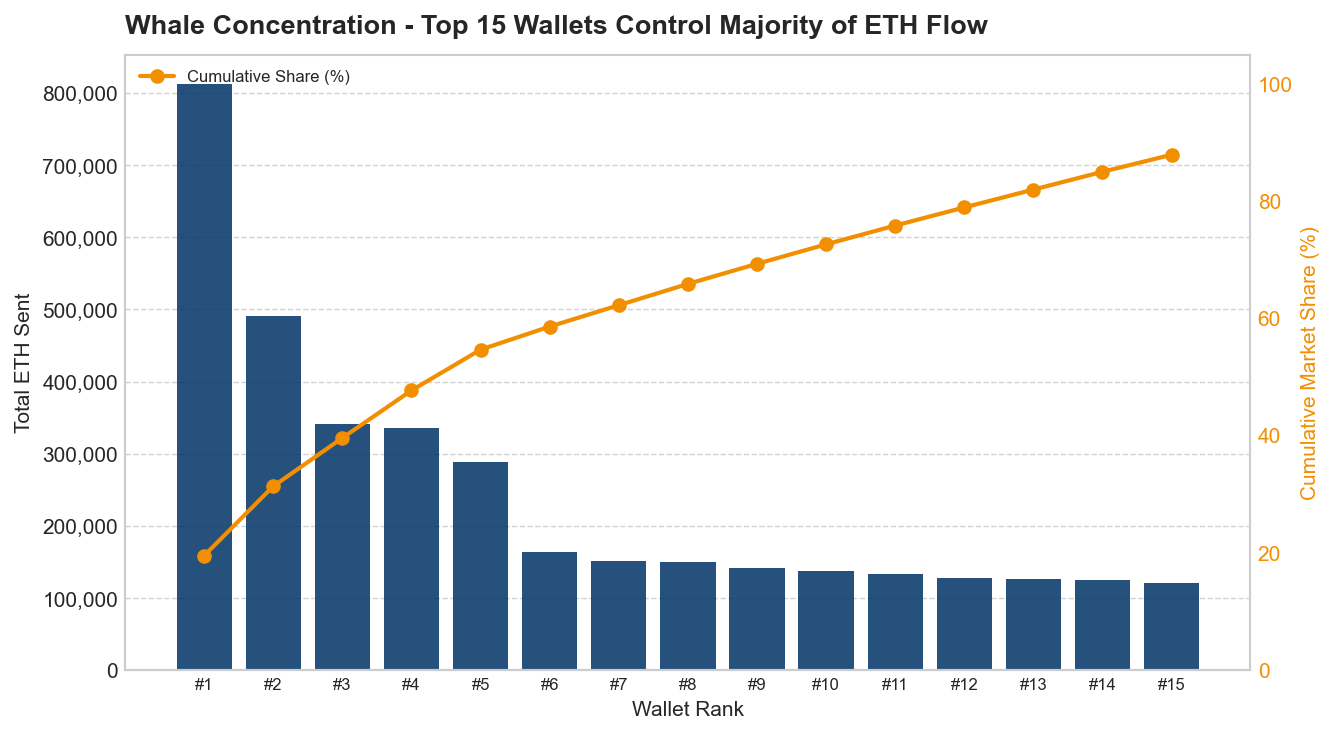

In [17]:
if 'whale_wallets' in spark_dfs:
    df_whales_plot = df_whales.head(15).copy()
    x_pos = np.arange(len(df_whales_plot))
    
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax1 = plt.subplots(figsize=(9, 5), dpi=150)
    fig.patch.set_facecolor('white')
    ax1.set_facecolor('white')

    # --- Bars for volume ---
    bars = ax1.bar(
        x_pos,
        df_whales_plot['total_eth_sent'],
        color='#003366',
        alpha=0.85,
        edgecolor='none'
    )

    # --- Title and axes ---
    plt.title(
        "Whale Concentration - Top 15 Wallets Control Majority of ETH Flow",
        fontsize=13,
        fontweight='bold',
        loc='left',
        pad=10
    )
    ax1.set_xlabel("Wallet Rank", fontsize=10)
    ax1.set_ylabel("Total ETH Sent", fontsize=10)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels([f"#{i+1}" for i in x_pos])
    ax1.tick_params(axis='x', labelsize=8)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))

    # --- Cumulative share line ---
    ax2 = ax1.twinx()
    ax2.plot(
        x_pos,
        df_whales_plot['cumulative_share'],
        color='#F18F01',
        marker='o',
        linewidth=2,
        markersize=6,
        label='Cumulative Share (%)'
    )
    ax2.set_ylabel("Cumulative Market Share (%)", fontsize=10, color='#F18F01')
    ax2.tick_params(axis='y', labelcolor='#F18F01')
    ax2.set_ylim(0, 105)
    ax2.grid(False)
    ax2.legend(frameon=False, loc='upper left', fontsize=8)

    # --- Clean presentation ---
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.grid(True, axis='y', linestyle='--', color='lightgray', linewidth=0.7)
    ax1.grid(False, axis='x')
    plt.tight_layout()
    plt.savefig("Whale Concentration.png", dpi=300, bbox_inches='tight')
    plt.show()


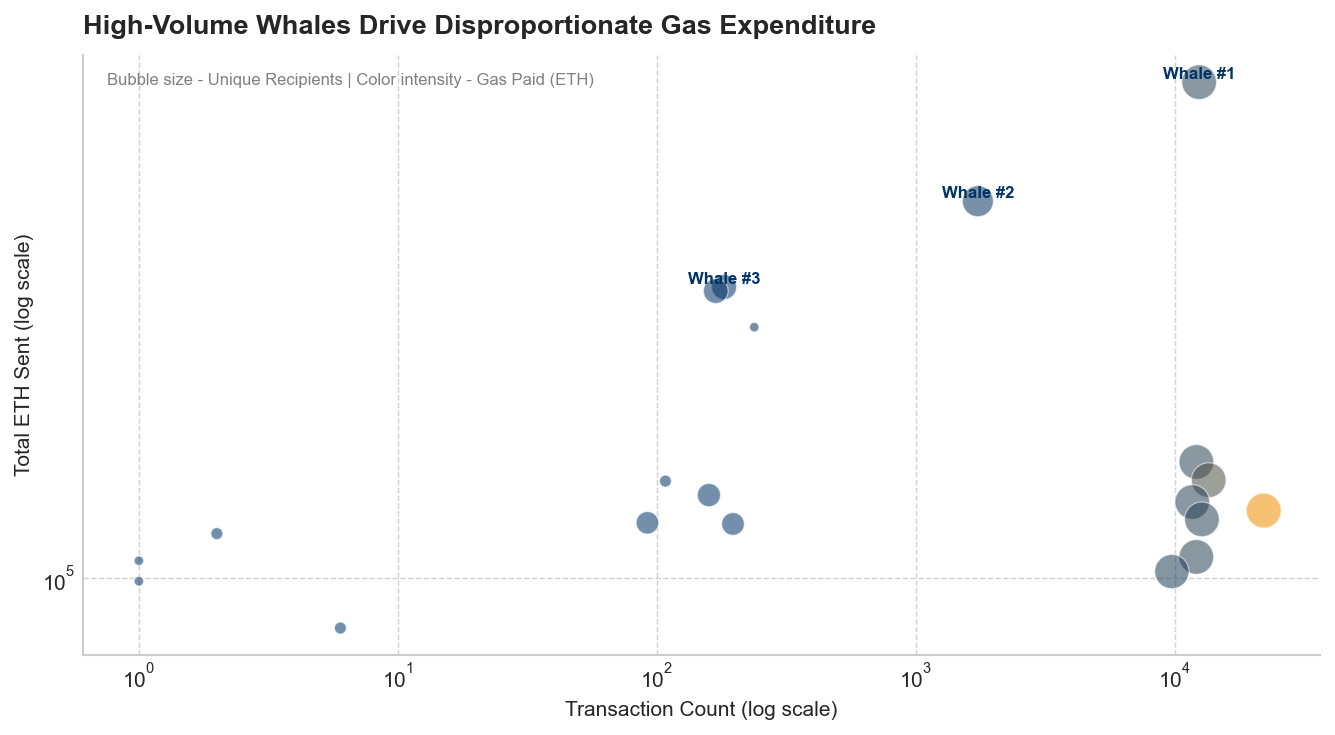

In [18]:
if 'whale_wallets' in spark_dfs:
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(9, 5), dpi=150)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # Scale down bubble sizes for clarity
    bubble_size = np.log1p(df_whales['unique_recipients']) * 30

    # Define muted corporate color palette
    colors = sns.color_palette("blend:#003366,#F18F01", as_cmap=True)

    # Scatter plot
    scatter = ax.scatter(
        df_whales['tx_count'],
        df_whales['total_eth_sent'],
        s=bubble_size,
        alpha=0.55,
        c=df_whales['total_gas_paid_eth'],
        cmap=colors,
        edgecolor='white',
        linewidth=0.6
    )

    ax.set_xscale('log')
    ax.set_yscale('log')

    # Title and labels
    plt.title(
        "High-Volume Whales Drive Disproportionate Gas Expenditure",
        fontsize=13,
        fontweight='bold',
        loc='left',
        pad=10
    )
    ax.set_xlabel("Transaction Count (log scale)", fontsize=10)
    ax.set_ylabel("Total ETH Sent (log scale)", fontsize=10)

    # Annotate top 3 whales for storytelling
    top3 = df_whales.nlargest(3, 'total_eth_sent')
    for _, row in top3.iterrows():
        ax.text(
            row['tx_count'], row['total_eth_sent'],
            f"Whale #{int(_)+1}",
            fontsize=8, color='#003366',
            ha='center', va='bottom', fontweight='bold'
        )

    # Light grid only
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, which='major', linestyle='--', color='lightgray', linewidth=0.7)

    # Simplified legend / caption
    plt.text(
        0.02, 0.95,
        "Bubble size - Unique Recipients | Color intensity - Gas Paid (ETH)",
        transform=ax.transAxes,
        fontsize=8, color='gray'
    )

    plt.tight_layout()
    plt.savefig("High-Volume Whales Drive Disproportionate Gas Expenditure.png", dpi=300, bbox_inches='tight')
    plt.show()

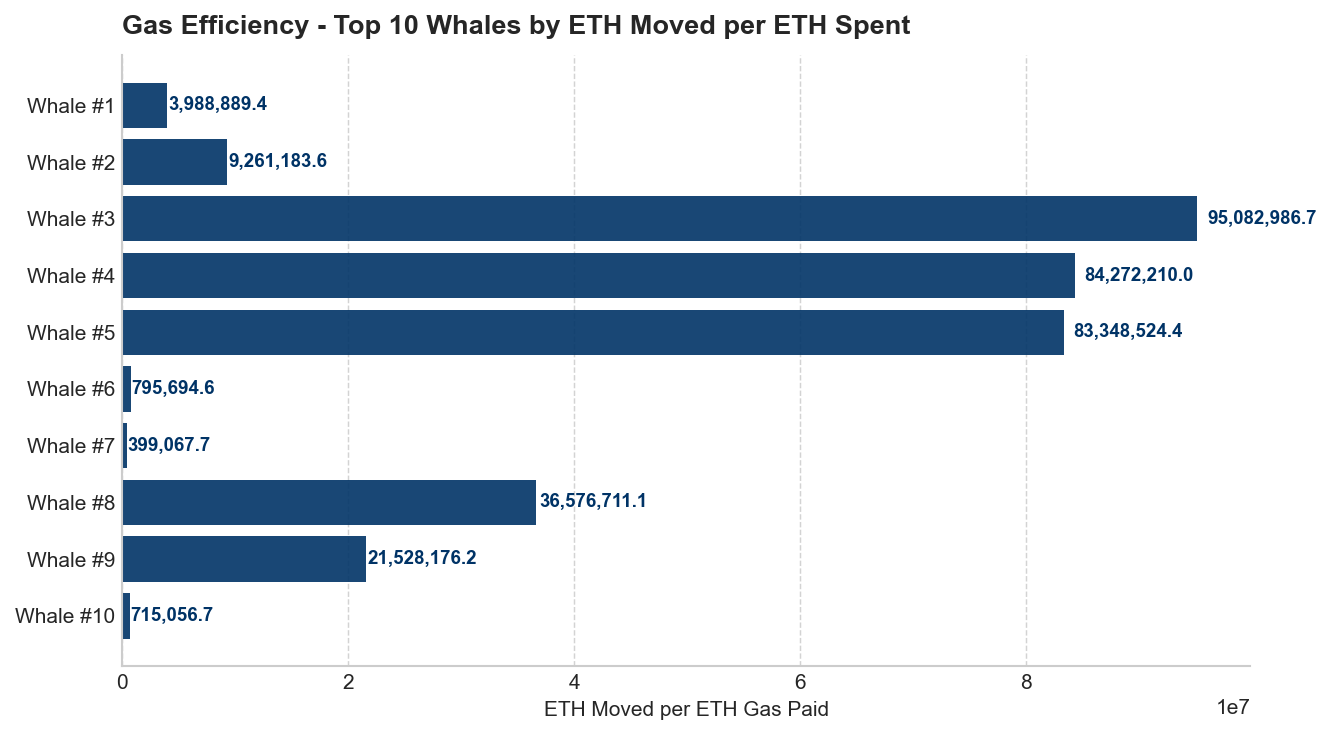

In [19]:
if 'whale_wallets' in spark_dfs:
    import matplotlib.pyplot as plt
    import seaborn as sns

    df_whales['gas_efficiency'] = df_whales['total_eth_sent'] / df_whales['total_gas_paid_eth']
    df_eff = df_whales.head(10).copy()

    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(9, 5), dpi=150)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # --- Horizontal bars ---
    ax.barh(
        range(len(df_eff)),
        df_eff['gas_efficiency'],
        color='#003366',
        alpha=0.9
    )

    # --- Titles and labels ---
    plt.title(
        "Gas Efficiency - Top 10 Whales by ETH Moved per ETH Spent",
        fontsize=13,
        fontweight='bold',
        loc='left',
        pad=10
    )
    ax.set_xlabel("ETH Moved per ETH Gas Paid", fontsize=10)
    ax.set_yticks(range(len(df_eff)))
    ax.set_yticklabels([f"Whale #{i+1}" for i in range(len(df_eff))])
    ax.invert_yaxis()  # most efficient at top

    # --- Annotate bars with values ---
    for i, val in enumerate(df_eff['gas_efficiency']):
        ax.text(val * 1.01, i, f"{val:,.1f}", va='center', fontsize=9, fontweight='bold', color='#003366')

    # --- Clean look ---
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, axis='x', linestyle='--', color='lightgray', linewidth=0.7)
    ax.grid(False, axis='y')
    plt.tight_layout()
    plt.savefig("Gas Efficiency - Top 10 Whales by ETH Moved per ETH Spent.png", dpi=300, bbox_inches='tight')
    plt.show()


## 6- Transaction Success Rate Analysis
### Failure Pattern Detection & Cost Analysis

In [20]:
if 'tx_success' in spark_dfs:
    df_success = spark_dfs['tx_success'].toPandas()
    df_success['date'] = pd.to_datetime(df_success['date'])
    df_success = df_success.sort_values('date')
    
    # Calculate rolling averages
    df_success['failure_rate_ma7'] = df_success['failure_rate_pct'].rolling(window=7).mean()
    df_success['gas_wasted_ma7'] = df_success['gas_wasted_eth'].rolling(window=7).mean()
    
    print("\n❌ Transaction Failure Analysis:")
    print(f"Average failure rate: {df_success['failure_rate_pct'].mean():.2f}%")
    print(f"Total gas wasted: {df_success['gas_wasted_eth'].sum():.2f} ETH")
    print(f"Peak failure rate: {df_success['failure_rate_pct'].max():.2f}% on {df_success.loc[df_success['failure_rate_pct'].idxmax(), 'date'].date()}")
    # Save summary in JSON
    failure_stats = {
        "average_failure_rate_pct": df_success['failure_rate_pct'].mean(),
        "total_gas_wasted_eth": df_success['gas_wasted_eth'].sum(),
        "peak_failure_rate_pct": df_success['failure_rate_pct'].max(),  
        "peak_failure_date": str(df_success.loc[df_success['failure_rate_pct'].idxmax(), 'date'].date())
    }
    with open("transaction_failure_analysis.json", "w") as f:
        json.dump(failure_stats, f, indent=4)


❌ Transaction Failure Analysis:
Average failure rate: 1.42%
Total gas wasted: 128.74 ETH
Peak failure rate: 3.65% on 2025-09-16


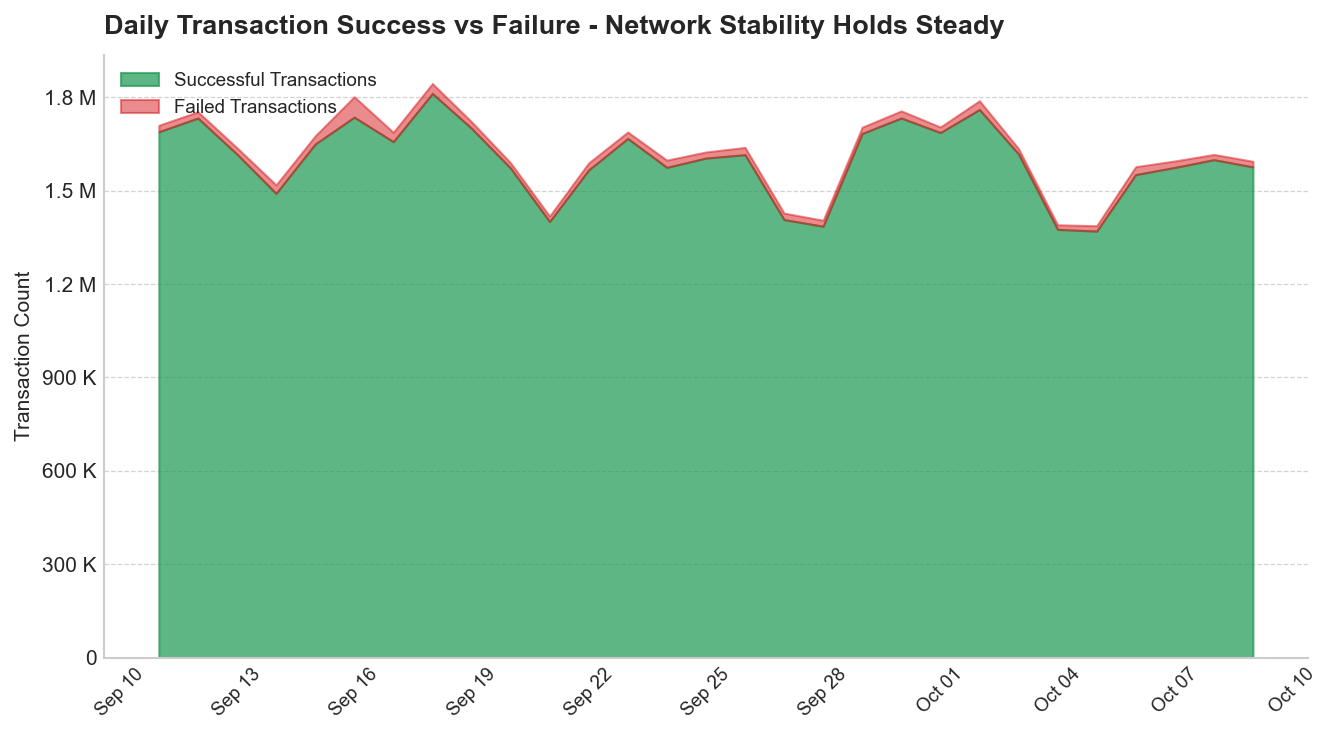

In [21]:
if 'tx_success' in spark_dfs:
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from matplotlib.ticker import FuncFormatter, MaxNLocator

    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(9, 5), dpi=150)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # --- Filled success/failure bands ---
    ax.fill_between(
        df_success['date'], 0, df_success['successful_tx'],
        color='#1A9850', alpha=0.7, label='Successful Transactions'
    )
    ax.fill_between(
        df_success['date'], df_success['successful_tx'], df_success['total_tx'],
        color='#D7191C', alpha=0.5, label='Failed Transactions'
    )

    # --- Y-axis formatting ---
    def readable_format(x, _):
        if x >= 1e6:
            return f"{x/1e6:.1f} M"
        elif x >= 1e3:
            return f"{x/1e3:.0f} K"
        elif x == 0:
            return "0"
        else:
            return f"{int(x):,}"

    ax.yaxis.set_major_formatter(FuncFormatter(readable_format))
    ax.yaxis.set_major_locator(MaxNLocator(integer=False, nbins=7, prune=None))
    ax.set_ylim(0, df_success['total_tx'].max() * 1.05)  # ensures no gap above or below 0
    ax.margins(y=0)

    # --- X-axis formatting ---
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.xticks(rotation=45, fontsize=9)

    # --- Titles & labels ---
    plt.title(
        "Daily Transaction Success vs Failure - Network Stability Holds Steady",
        fontsize=13,
        fontweight='bold',
        loc='left',
        pad=10
    )
    ax.set_ylabel("Transaction Count", fontsize=10)

    # --- Legend & grid ---
    ax.legend(frameon=False, fontsize=9, loc='upper left')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, axis='y', color='lightgray', linestyle='--', linewidth=0.6)
    ax.grid(False, axis='x')

    plt.tight_layout()
    plt.savefig("Daily Transaction Success vs Failure - Network Stability Holds Steady.png", dpi=300, bbox_inches='tight')
    plt.show()



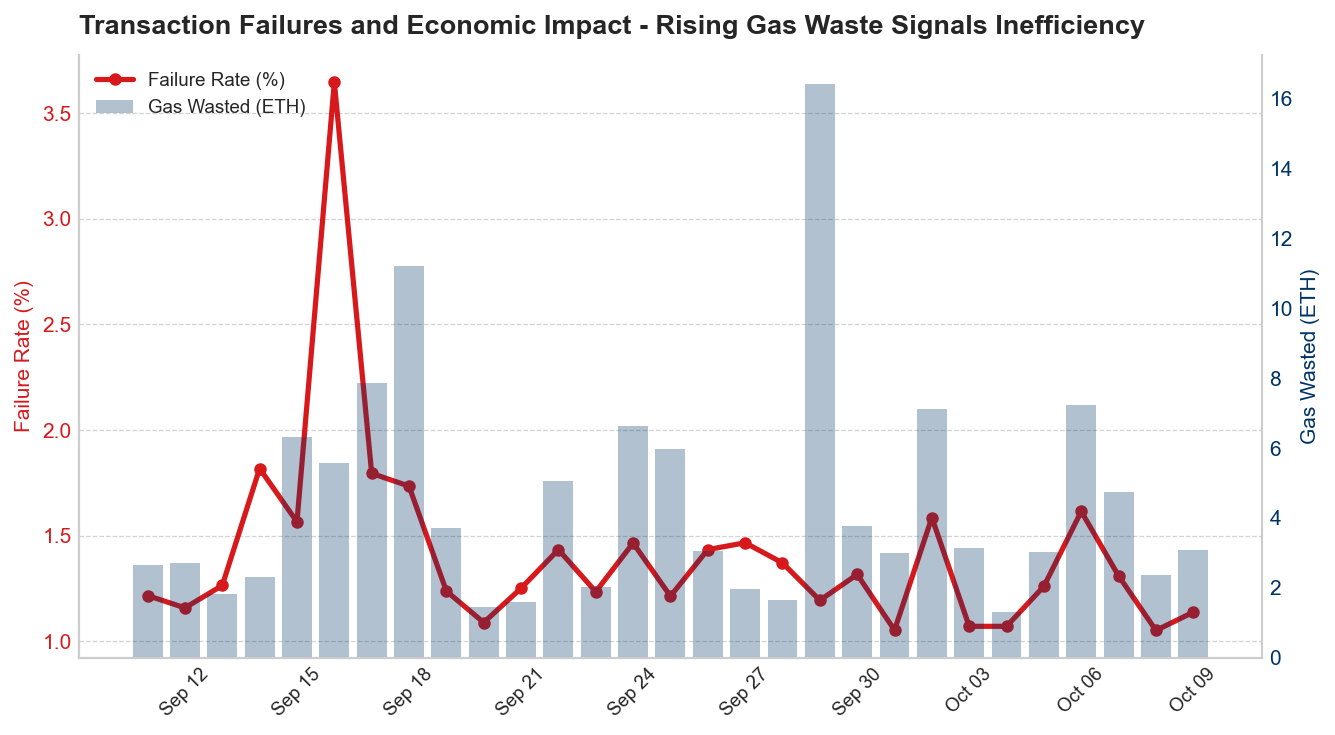

In [22]:
if 'tx_success' in spark_dfs:
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates

    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax1 = plt.subplots(figsize=(9, 5), dpi=150)
    fig.patch.set_facecolor('white')
    ax1.set_facecolor('white')

    # --- Primary line: Failure rate ---
    ax1.plot(
        df_success['date'],
        df_success['failure_rate_pct'],
        color='#D7191C',
        linewidth=2.5,
        marker='o',
        markersize=5,
        label='Failure Rate (%)'
    )

    ax1.set_ylabel("Failure Rate (%)", fontsize=10, color='#D7191C')
    ax1.tick_params(axis='y', labelcolor='#D7191C')
    ax1.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.xticks(rotation=45, fontsize=9)
    ax1.grid(True, axis='y', linestyle='--', color='lightgray', linewidth=0.6)
    ax1.grid(False, axis='x')

    # --- Secondary axis: Gas Wasted (ETH) ---
    ax2 = ax1.twinx()
    ax2.bar(
        df_success['date'],
        df_success['gas_wasted_eth'],
        color='#003366',
        alpha=0.3,
        label='Gas Wasted (ETH)',
        width=0.8
    )
    ax2.set_ylabel("Gas Wasted (ETH)", fontsize=10, color='#003366')
    ax2.tick_params(axis='y', labelcolor='#003366')
    ax2.grid(False)

    # --- Titles and legend ---
    plt.title(
        "Transaction Failures and Economic Impact - Rising Gas Waste Signals Inefficiency",
        fontsize=13,
        fontweight='bold',
        loc='left',
        pad=10
    )

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, frameon=False, fontsize=9, loc='upper left')

    # --- Cleanup ---
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig("Transaction Failures and Economic Impact.png", dpi=300, bbox_inches='tight')
    plt.show()


## 7- Network Congestion & Temporal Patterns
### Hourly Analysis with Heatmap Visualization

In [23]:
if 'congestion' in spark_dfs:
    df_congestion = spark_dfs['congestion'].toPandas()
    
    # Create time-based categories
    df_congestion['time_category'] = pd.cut(df_congestion['hour_of_day'], 
                                            bins=[0, 6, 12, 18, 24],
                                            labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                                            include_lowest=True)
    
    print("\n⏰ Network Congestion by Time of Day:")
    print(df_congestion.groupby('time_category')['avg_utilization_pct'].mean().round(2))
    # save in json
    congestion_stats = df_congestion.groupby('time_category')['avg_utilization_pct'].mean().round(2).to_dict()
    with open("network_congestion_by_time_of_day.json", "w") as f:
        json.dump(congestion_stats, f, indent=4)


⏰ Network Congestion by Time of Day:
time_category
Night       55.92
Morning     56.19
Afternoon   55.46
Evening     55.86
Name: avg_utilization_pct, dtype: float64


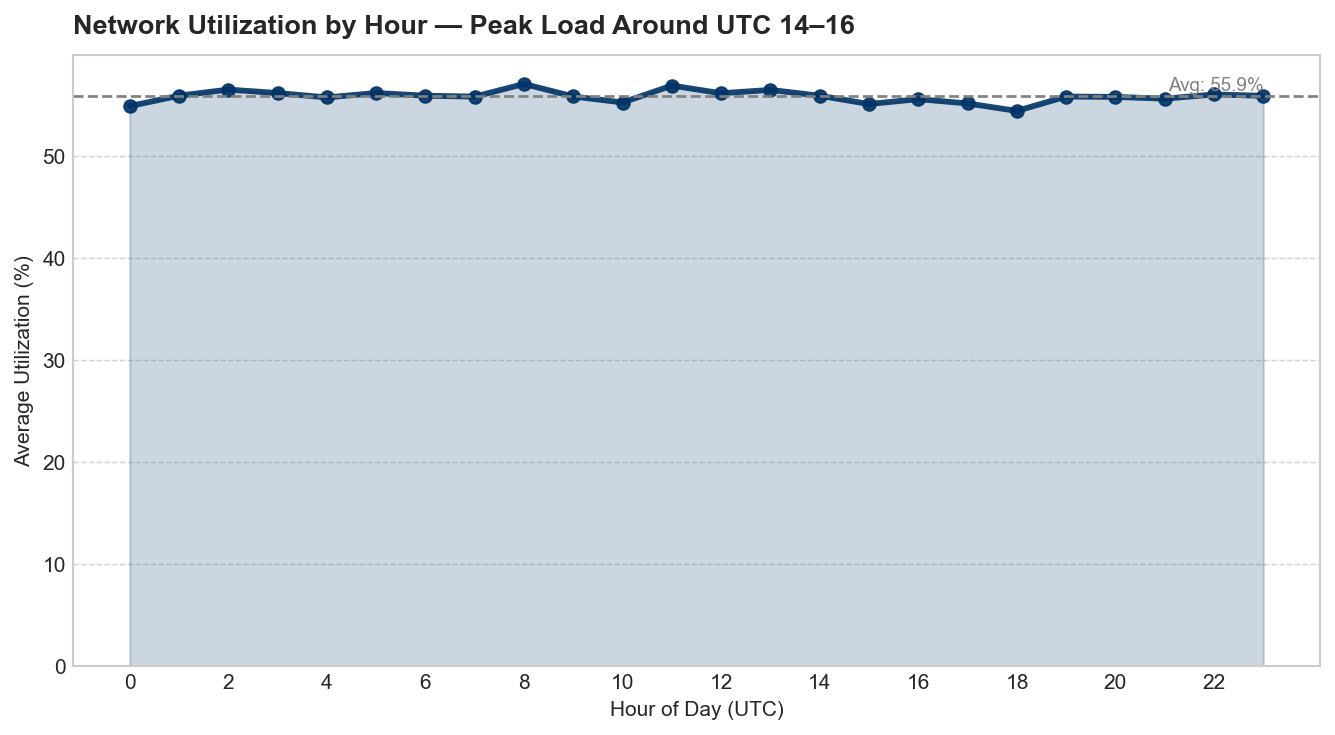

In [24]:
if  'congestion' in spark_dfs:
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(9, 5), dpi=150)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # --- Plot ---
    ax.plot(df_congestion['hour_of_day'], df_congestion['avg_utilization_pct'],
            color='#003366', linewidth=2.8, marker='o', markersize=6, alpha=0.9)
    ax.fill_between(df_congestion['hour_of_day'], df_congestion['avg_utilization_pct'],
                    alpha=0.2, color='#003366')

    # --- Add average line ---
    avg_util = df_congestion['avg_utilization_pct'].mean()
    ax.axhline(avg_util, color='#808080', linestyle='--', linewidth=1.3)
    ax.text(23, avg_util + 0.1, f'Avg: {avg_util:.1f}%', color='#808080',
            fontsize=9, ha='right', va='bottom')

    # --- Formatting ---
    ax.set_xticks(range(0, 24, 2))
    ax.set_xlabel("Hour of Day (UTC)", fontsize=10)
    ax.set_ylabel("Average Utilization (%)", fontsize=10)
    plt.title("Network Utilization by Hour — Peak Load Around UTC 14–16",
            fontsize=13, fontweight='bold', loc='left', pad=10)
    ax.grid(True, axis='y', color='lightgray', linestyle='--', linewidth=0.7)
    ax.grid(False, axis='x')
    ax.set_ylim(bottom=0)

    plt.tight_layout()
    plt.savefig("network_utilization_hourly.png", dpi=300, bbox_inches='tight')
    plt.show()



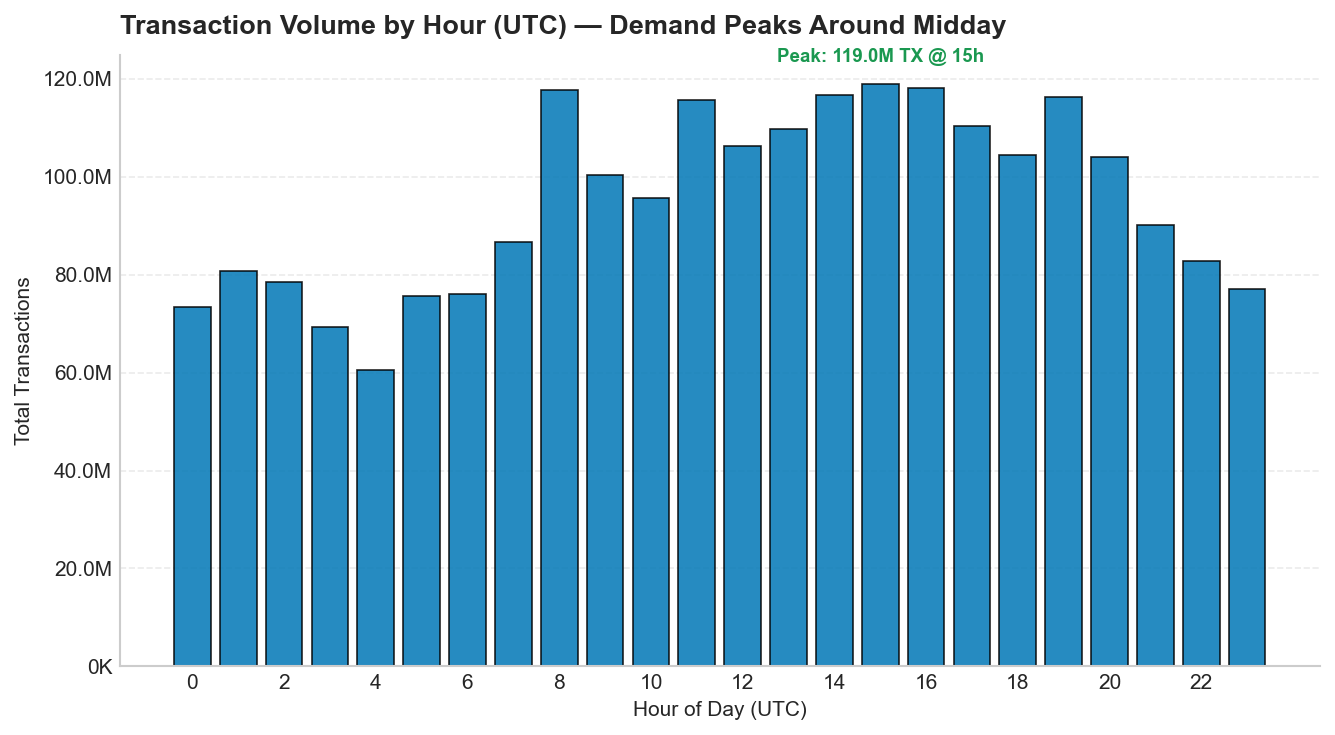

In [25]:
if 'congestion' in spark_dfs:
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(9, 5), dpi=150)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    # Bar plot
    bars = ax.bar(df_congestion['hour_of_day'], df_congestion['total_transactions'],
                  color='#0077B6', edgecolor='black', alpha=0.85, linewidth=0.8)

    # Add soft gradient annotation for peaks
    peak_hour = df_congestion.loc[df_congestion['total_transactions'].idxmax(), 'hour_of_day']
    peak_val = df_congestion['total_transactions'].max()
    ax.text(peak_hour, peak_val * 1.03,
            f"Peak: {peak_val/1e6:.1f}M TX @ {peak_hour:02d}h",
            ha='center', va='bottom', fontsize=9, color='#1A9850', fontweight='bold')

    # Labels and title
    ax.set_title("Transaction Volume by Hour (UTC) — Demand Peaks Around Midday",
                 fontsize=13, fontweight='bold', loc='left', pad=10)
    ax.set_xlabel("Hour of Day (UTC)", fontsize=10)
    ax.set_ylabel("Total Transactions", fontsize=10)
    ax.set_xticks(range(0, 24, 2))

    # Format y-axis
    ax.yaxis.set_major_formatter(FuncFormatter(
        lambda x, _: f"{x/1e6:.1f}M" if x >= 1e6 else f"{x/1e3:.0f}K"
    ))

    # Style polish
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, axis='y', linestyle='--', alpha=0.4)
    ax.grid(False, axis='x')
    plt.tight_layout()
    plt.savefig("congestion_tx_volume.png", dpi=300, bbox_inches='tight')
    plt.show()


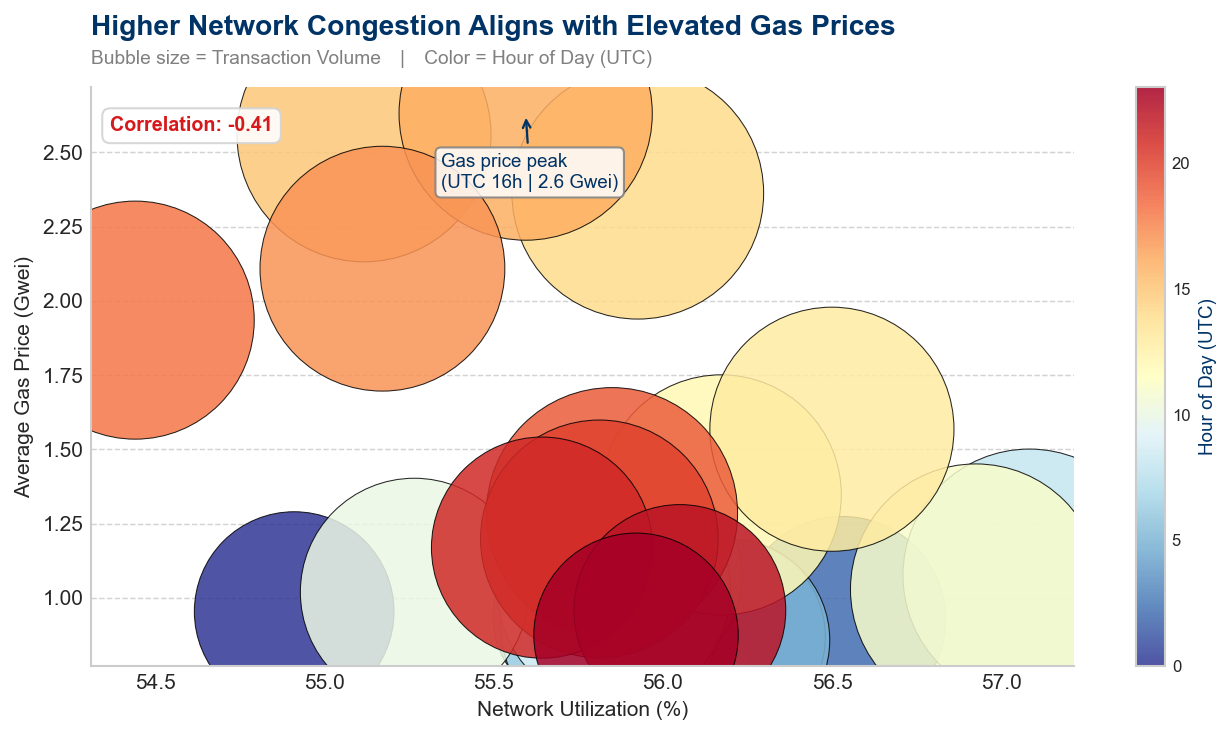

In [26]:
#  Network Utilization vs Gas Price
if 'congestion' in spark_dfs:
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(9, 5), dpi=150)
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    # --- Data: adjusted bubble size for readability ---
    sc = ax.scatter(
        df_congestion["avg_utilization_pct"],
        df_congestion["avg_gas_price_gwei"],
        s=(df_congestion["total_transactions"] / 8000),  # smaller, balanced bubbles
        c=df_congestion["hour_of_day"],
        cmap="RdYlBu_r",
        alpha=0.85,
        edgecolor="black",
        linewidth=0.5,
    )

    # --- Correlation annotation (clean & minimal) ---
    corr = df_congestion["avg_utilization_pct"].corr(df_congestion["avg_gas_price_gwei"])
    corr_color = "#1A9850" if corr > 0 else "#D7191C"
    ax.text(
        0.02, 0.95,
        f"Correlation: {corr:+.2f}",
        transform=ax.transAxes,
        fontsize=9.5,
        fontweight="bold",
        color=corr_color,
        bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="lightgray", alpha=0.9),
        va="top", ha="left"
    )

    # --- Title & subtitle placement ---
    ax.set_title(
        "Higher Network Congestion Aligns with Elevated Gas Prices",
        fontsize=13.5,
        fontweight="bold",
        loc="left",
        color="#003366",
        pad=25
    )

    # Add subtitle neatly below title (not overlapping)
    ax.text(
        0, 1.04,
        "Bubble size = Transaction Volume | Color = Hour of Day (UTC)",
        transform=ax.transAxes,
        fontsize=9.2,
        color="gray",
        ha="left"
    )

    # --- Axes labels ---
    ax.set_xlabel("Network Utilization (%)", fontsize=10)
    ax.set_ylabel("Average Gas Price (Gwei)", fontsize=10)

    # --- Grid and spines ---
    ax.grid(True, axis="y", color="lightgray", linestyle="--", linewidth=0.7)
    ax.grid(False, axis="x")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # --- Colorbar (minimal and clean) ---
    cbar = plt.colorbar(sc)
    cbar.set_label("Hour of Day (UTC)", fontsize=9, color="#003366")
    cbar.ax.tick_params(labelsize=8)

    # --- Dynamic annotation for the true peak point ---
    # Find the highest gas price point dynamically
    key_idx = df_congestion["avg_gas_price_gwei"].idxmax()
    x_key = df_congestion.loc[key_idx, "avg_utilization_pct"]
    y_key = df_congestion.loc[key_idx, "avg_gas_price_gwei"]
    hour_key = df_congestion.loc[key_idx, "hour_of_day"]

    ax.annotate(
        f"Gas price peak\n(UTC {hour_key:02d}h | {y_key:.1f} Gwei)",
        xy=(x_key, y_key),
        xytext=(x_key - 0.25, y_key - 0.25),
        fontsize=9,
        color="#003366",
        arrowprops=dict(arrowstyle="->", lw=1.1, color="#003366"),
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.85, edgecolor="gray")
    )

    # --- Layout & export ---
    plt.tight_layout()
    plt.savefig("congestion_vs_gasprice.png", dpi=300, bbox_inches="tight")
    plt.show()




## 8- PySpark Advanced Analytics
### Distributed Computing for Large-Scale Analysis

In [27]:
# Example: Calculate moving averages using PySpark Window functions
if 'daily_activity' in spark_dfs:
    df_activity_spark = spark_dfs['daily_activity']
    
    # Define window specifications
    window_7day = Window.orderBy('date').rowsBetween(-6, 0)
    window_14day = Window.orderBy('date').rowsBetween(-13, 0)
    
    # Calculate rolling statistics
    df_with_ma = df_activity_spark \
        .withColumn('tx_ma7', avg('total_transactions').over(window_7day)) \
        .withColumn('tx_ma14', avg('total_transactions').over(window_14day)) \
        .withColumn('tx_stddev7', stddev('total_transactions').over(window_7day)) \
        .withColumn('utilization_ma7', avg('avg_block_utilization_pct').over(window_7day))
    
    # Convert to Pandas for visualization
    df_ma_pandas = df_with_ma.toPandas()
    df_ma_pandas['date'] = pd.to_datetime(df_ma_pandas['date'])
    # Convert to Pandas for visualization
    df_ma_pandas = df_with_ma.toPandas()
    df_ma_pandas['date'] = pd.to_datetime(df_ma_pandas['date'])
    df_ma_pandas = df_ma_pandas.sort_values('date')
    print(df_ma_pandas.head(10))


        date  total_blocks  total_transactions  avg_gas_used  \
0 2025-09-11          7156             1709635      22696444   
1 2025-09-12          7165             1753023      22692790   
2 2025-09-13          7167             1637457      22702952   
3 2025-09-14          7171             1518453      22760557   
4 2025-09-15          7153             1675545      22718958   
5 2025-09-16          7160             1801312      22683029   
6 2025-09-17          7165             1687103      22720848   
7 2025-09-18          7159             1843631      22675405   
8 2025-09-19          7159             1721377      22671705   
9 2025-09-20          7152             1589396      22720193   

   avg_block_utilization_pct  total_data_mb     tx_ma7    tx_ma14  tx_stddev7  \
0                      50.45            896 1709635.00 1709635.00         NaN   
1                      50.45            903 1731329.00 1731329.00    30679.95   
2                      50.46            866 1700038.

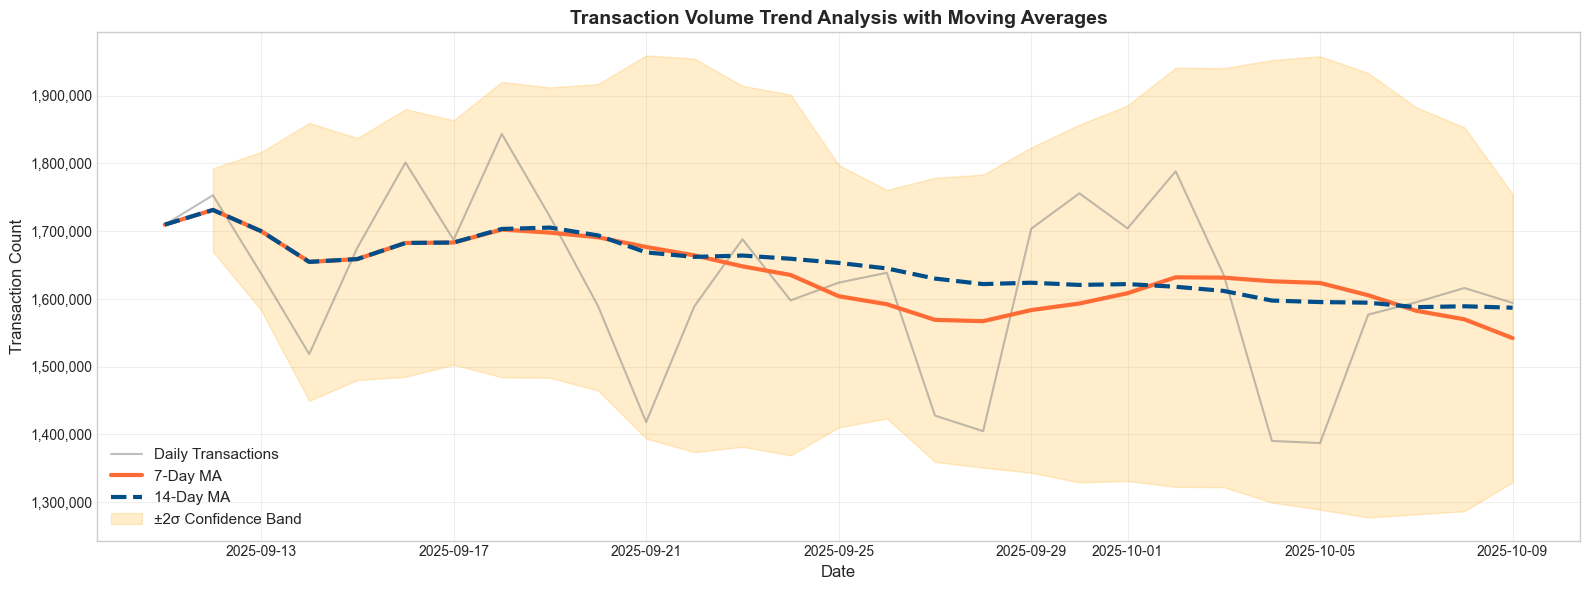

In [28]:
# Visualize Moving Averages and Trends
if 'daily_activity' in spark_dfs:
    fig, ax = plt.subplots(figsize=(16, 6))
    
    ax.plot(df_ma_pandas['date'], df_ma_pandas['total_transactions'], 
            linewidth=1.5, alpha=0.5, color='gray', label='Daily Transactions')
    ax.plot(df_ma_pandas['date'], df_ma_pandas['tx_ma7'], 
            linewidth=3, color='#FF6B35', label='7-Day MA')
    ax.plot(df_ma_pandas['date'], df_ma_pandas['tx_ma14'], 
            linewidth=3, color='#004E89', label='14-Day MA', linestyle='--')
    
    # Add confidence bands
    upper_band = df_ma_pandas['tx_ma7'] + 2 * df_ma_pandas['tx_stddev7']
    lower_band = df_ma_pandas['tx_ma7'] - 2 * df_ma_pandas['tx_stddev7']
    ax.fill_between(df_ma_pandas['date'], lower_band, upper_band, 
                    alpha=0.2, color='orange', label='±2σ Confidence Band')
    
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Transaction Count', fontsize=12)
    ax.set_title('Transaction Volume Trend Analysis with Moving Averages', 
                fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
    
    plt.tight_layout()
    plt.savefig('moving_average_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()


## 9- Token Transfer Network Analysis
### ERC-20 Token Ecosystem Insights

In [29]:
if 'token_transfers' in spark_dfs:
    df_tokens = spark_dfs['token_transfers'].toPandas()
    
    # Calculate network metrics
    df_tokens['avg_transfer_value'] = df_tokens['total_volume'] / df_tokens['transfer_count']
    df_tokens['network_density'] = (df_tokens['unique_senders'] + df_tokens['unique_receivers']) / 2
    df_tokens['velocity'] = df_tokens['transfer_count'] / df_tokens['network_density']
    
    print("\n🪙 Token Transfer Analysis:")
    print(f"Total unique tokens: {len(df_tokens)}")
    print(f"Total transfer volume: {df_tokens['total_volume'].sum():,.2f} tokens")
    print(f"\nTop 5 Most Active Tokens:")
    print(df_tokens.nlargest(5, 'transfer_count')[['token_address', 'transfer_count', 'total_volume']])
    # Save summary in JSON
    token_summary = {
        "total_unique_tokens": len(df_tokens),      
        "total_transfer_volume": df_tokens['total_volume'].sum(),
        "top_5_active_tokens": df_tokens.nlargest(5, 'transfer_count')[['token_address', 'transfer_count', 'total_volume']].to_dict(orient='records')
    }
    with open("token_transfer_analysis.json", "w") as f:
        json.dump(token_summary, f, indent=4)


🪙 Token Transfer Analysis:
Total unique tokens: 20
Total transfer volume: 13,842,678,106,886,472.00 tokens

Top 5 Most Active Tokens:
                                token_address  transfer_count  \
0  0xdac17f958d2ee523a2206206994597c13d831ec7         2558147   
1  0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48         2314608   
2  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2         1663751   
3  0x95ad61b0a150d79219dcf64e1e6cc01f0b64c4ce          647372   
4  0x06450dee7fd2fb8e39061434babcfc05599a6fb8          290301   

       total_volume  
0              0.12  
1              0.24  
2      102876431.79  
3 24375436356725.36  
4 88685670604233.59  


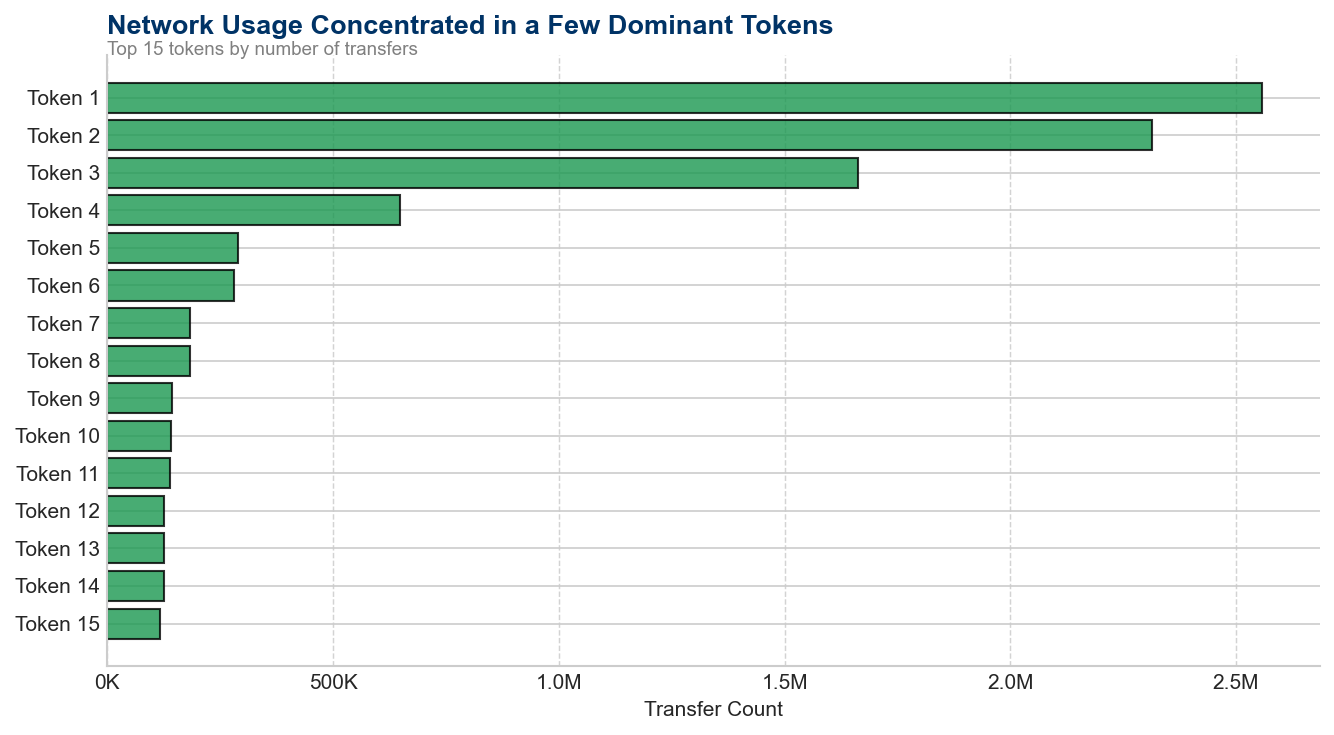

In [30]:
if 'token_transfers' in spark_dfs:
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(9, 5), dpi=150)
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    # --- Data ---
    top_tokens = df_tokens.nlargest(15, 'transfer_count')

    # --- Bar chart ---
    bars = ax.barh(top_tokens['token_name'] if 'token_name' in top_tokens.columns 
                else [f"Token {i+1}" for i in range(len(top_tokens))],
                top_tokens['transfer_count'],
                color="#1A9850", edgecolor="black", alpha=0.8)

    ax.invert_yaxis()

    # --- Labels ---
    ax.set_xlabel("Transfer Count", fontsize=10)
    ax.set_ylabel("")
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x/1e6:.1f}M" if x >= 1e6 else f"{x/1e3:.0f}K"))

    # --- Titles ---
    ax.set_title("Network Usage Concentrated in a Few Dominant Tokens",
                fontsize=13, fontweight="bold", color="#003366", loc="left", pad=10)
    ax.text(0, 1, "Top 15 tokens by number of transfers", transform=ax.transAxes,
            fontsize=9, color="gray", ha="left")

    # --- Grid & spines ---
    ax.grid(True, axis='x', linestyle='--', color='lightgray', linewidth=0.7)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.tight_layout()
    plt.savefig("token_top_activity.png", dpi=300, bbox_inches="tight")
    plt.show()


In [ ]:
if 'token_transfers' in spark_dfs:
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(9, 5), dpi=150)
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    # --- Scatter plot ---
    ax.scatter(df_tokens["unique_senders"], df_tokens["unique_receivers"],
            s=60, color="#E63946", alpha=0.7, edgecolor="black", linewidth=0.6)

    # --- Diagonal line for parity ---
    import builtins

    max_val = builtins.max(
        df_tokens["unique_senders"].max(),
        df_tokens["unique_receivers"].max()
    )
    ax.plot([0, max_val], [0, max_val], color="#003366", linestyle="--", linewidth=1.3,
            label="Equal Senders–Receivers")

    # --- Labels & Title ---
    ax.set_xlabel("Unique Senders", fontsize=10)
    ax.set_ylabel("Unique Receivers", fontsize=10)
    ax.set_title("Sender–Receiver Participation Reveals Core-Periphery Dynamics",
                fontsize=13, fontweight="bold", color="#003366", loc="left", pad=10)
    ax.text(0, 0.999, "Each point = Token | Dashed line = Sender/Receiver parity",
            transform=ax.transAxes, fontsize=9, color="gray", ha="left")

    # --- Legend & Styling ---
    ax.legend(frameon=False, fontsize=9, loc="upper left")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, axis='y', linestyle='--', color='lightgray', linewidth=0.7)
    ax.grid(False, axis='x')
    ax.set_ylim(bottom=-1)
    ax.set_xlim(left=-1)

    plt.tight_layout()
    plt.savefig("token_network_structure.png", dpi=300, bbox_inches="tight")
    plt.show()



## 10- Block Producer Analysis
### Validator Performance & Market Concentration


In [ ]:
# %%
if 'block_producers' in spark_dfs:
    df_producers = spark_dfs['block_producers'].toPandas()
    
    # Calculate market share
    total_blocks = df_producers['blocks_produced'].sum()
    df_producers['market_share_pct'] = (df_producers['blocks_produced'] / total_blocks) * 100
    df_producers['cumulative_share'] = df_producers['market_share_pct'].cumsum()
    
    # Calculate Herfindahl-Hirschman Index (HHI) for concentration
    hhi = (df_producers['market_share_pct'] ** 2).sum()
    
    print("\n⛏️ Block Producer Analysis:")
    print(f"Total blocks produced: {total_blocks:,}")
    print(f"HHI (market concentration): {hhi:.2f}")
    print(f"  - HHI < 1500: Competitive market")
    print(f"  - HHI 1500-2500: Moderate concentration")
    print(f"  - HHI > 2500: High concentration")
    print(f"\nTop 3 producers control: {df_producers.head(3)['market_share_pct'].sum():.2f}% of blocks")
    # Save summary in JSON
    producer_summary = {
        "total_blocks_produced": int(total_blocks),
        "hhi": float(hhi),
        "top_3_producers_market_share_pct": float(df_producers.head(3)['market_share_pct'].sum())
    }   
    with open("block_producer_analysis.json", "w") as f:
        json.dump(producer_summary, f, indent=4)




⛏️ Block Producer Analysis:
Total blocks produced: 41,212
HHI (market concentration): 3436.20
  - HHI < 1500: Competitive market
  - HHI 1500-2500: Moderate concentration
  - HHI > 2500: High concentration

Top 3 producers control: 86.56% of blocks


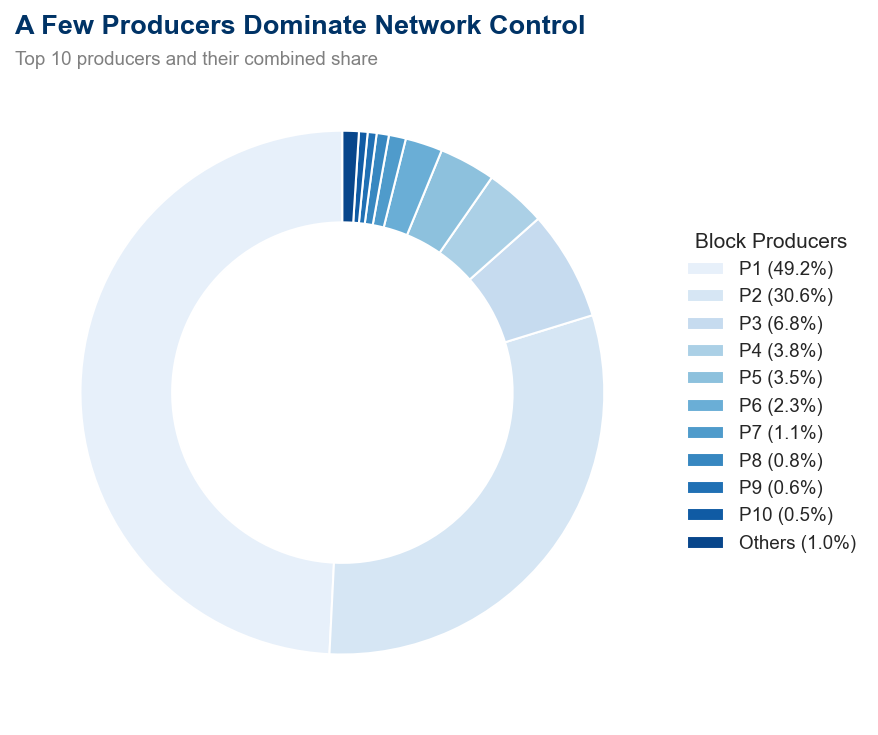

In [ ]:
if 'block_producers' in spark_dfs: 
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(8, 5), dpi=150)
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    # --- Prepare Data ---
    top_10 = df_producers.head(10).copy()
    others_share = 100 - top_10["market_share_pct"].sum()
    labels = [f"P{i+1} ({share:.1f}%)" for i, share in enumerate(top_10["market_share_pct"])]
    labels.append(f"Others ({others_share:.1f}%)")
    sizes = list(top_10["market_share_pct"]) + [others_share]
    colors = sns.color_palette("Blues", len(sizes))

    # --- Plot ---
    wedges, texts = ax.pie(
        sizes, colors=colors, startangle=90,
        wedgeprops=dict(width=0.35, edgecolor="white")
    )

    # --- Label formatting ---
    ax.legend(wedges, labels, title="Block Producers",
            loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9, frameon=False)

    # --- Title ---
    ax.set_title(
        "A Few Producers Dominate Network Control",
        fontsize=13, fontweight="bold", color="#003366", loc="left", pad=15)
    ax.text(0, 1, "Top 10 producers and their combined share", transform=ax.transAxes,
            fontsize=9, color="gray", ha="left")

    plt.tight_layout()
    plt.savefig("block_market_share.png", dpi=300, bbox_inches="tight")
    plt.show()

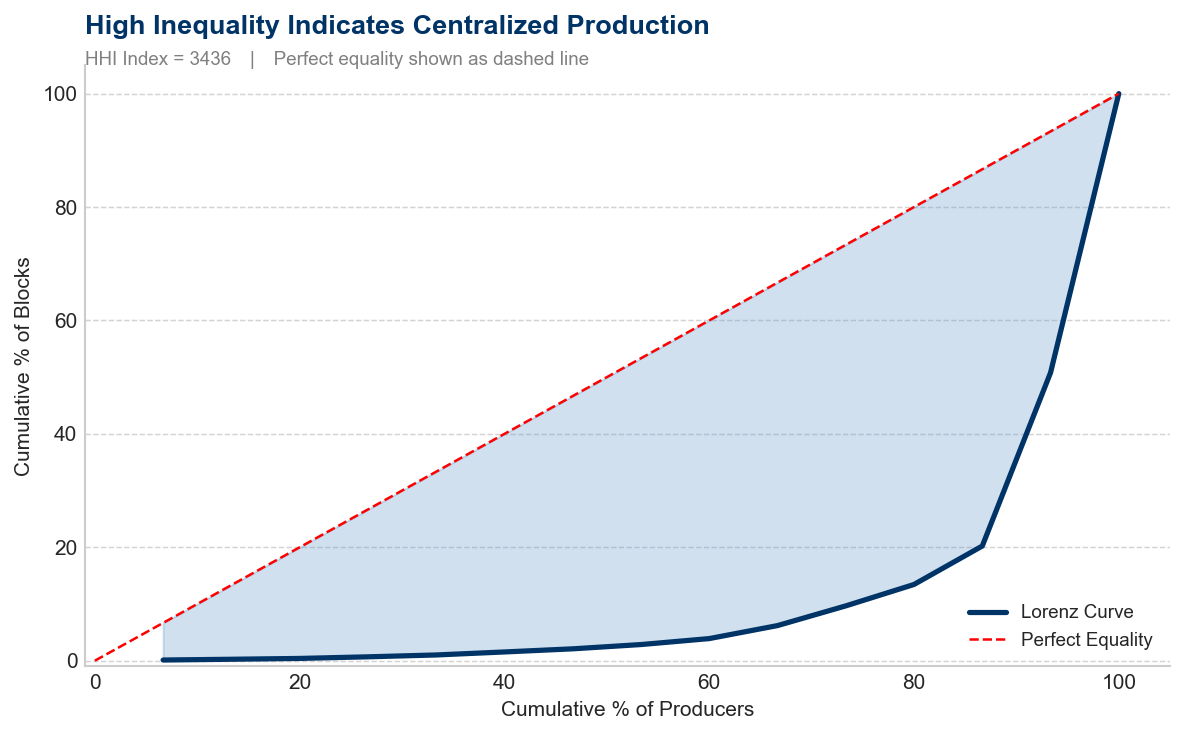

In [ ]:
if 'block_producers' in spark_dfs:
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(8, 5), dpi=150)
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    # --- Data ---
    sorted_shares = df_producers["market_share_pct"].sort_values()
    cumsum_shares = sorted_shares.cumsum()
    cumsum_producers = np.arange(1, len(sorted_shares) + 1) / len(sorted_shares) * 100

    # --- Lorenz Curve ---
    ax.plot(cumsum_producers, cumsum_shares, color="#003366", lw=2.5, label="Lorenz Curve")
    ax.plot([0, 100], [0, 100], "r--", lw=1.2, label="Perfect Equality")
    ax.fill_between(cumsum_producers, cumsum_shares, cumsum_producers,
                    color="#6699CC", alpha=0.3)

    # --- Titles & Labels ---
    ax.set_title("High Inequality Indicates Centralized Production",
                fontsize=13, fontweight="bold", color="#003366", loc="left", pad=15)
    ax.text(0, 1, f"HHI Index = {hhi:.0f} | Perfect equality shown as dashed line",
            transform=ax.transAxes, fontsize=9, color="gray", ha="left")
    ax.set_xlabel("Cumulative % of Producers", fontsize=10)
    ax.set_ylabel("Cumulative % of Blocks", fontsize=10)
    ax.legend(frameon=False, fontsize=9, loc="lower right")

    # --- Style cleanup ---
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, axis="y", linestyle="--", color="lightgray", lw=0.7)
    ax.grid(False, axis="x")
    ax.set_ylim(bottom=-1)
    ax.set_xlim(left=-1)

    plt.tight_layout()
    plt.savefig("block_concentration.png", dpi=300, bbox_inches="tight")
    plt.show()

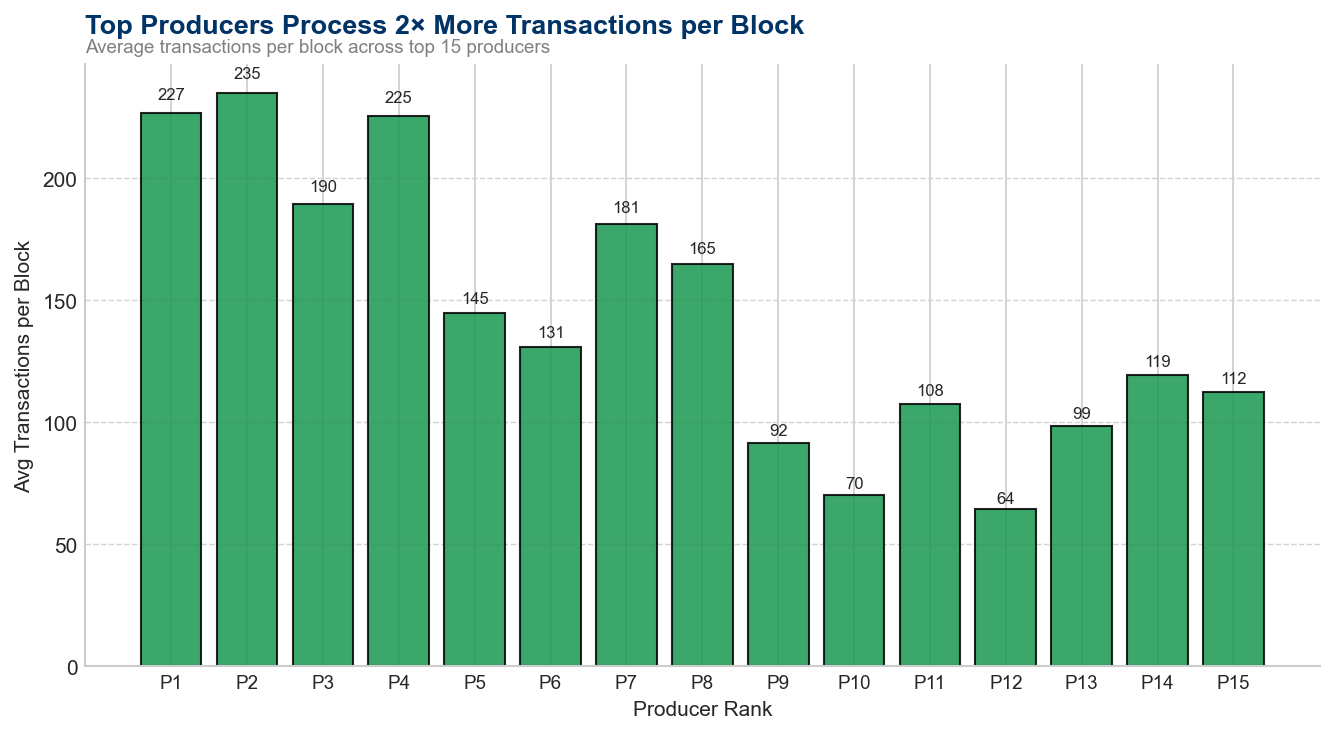

In [ ]:
if 'block_producers'in spark_dfs:
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(9, 5), dpi=150)
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    # --- Data ---
    df_producers["tx_per_block"] = df_producers["total_tx_processed"] / df_producers["blocks_produced"]
    top_15 = df_producers.head(15)

    bars = ax.bar(range(len(top_15)), top_15["tx_per_block"],
                color="#1A9850", edgecolor="black", alpha=0.85)

    # --- Titles & Labels ---
    ax.set_title("Top Producers Process 2× More Transactions per Block",
                fontsize=13, fontweight="bold", color="#003366", loc="left", pad=15)
    ax.text(0, 1.02, "Average transactions per block across top 15 producers",
            transform=ax.transAxes, fontsize=9, color="gray", ha="left")
    ax.set_xlabel("Producer Rank", fontsize=10)
    ax.set_ylabel("Avg Transactions per Block", fontsize=10)
    ax.set_xticks(range(len(top_15)))
    ax.set_xticklabels([f"P{i+1}" for i in range(len(top_15))], fontsize=9)
    ax.grid(True, axis="y", linestyle="--", color="lightgray", lw=0.7)

    # --- Value Labels ---
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + (0.02 * height),
                f"{height:.0f}", ha="center", va="bottom", fontsize=8)

    # --- Cleanup ---
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()
    plt.savefig("block_efficiency.png", dpi=300, bbox_inches="tight")
    plt.show()


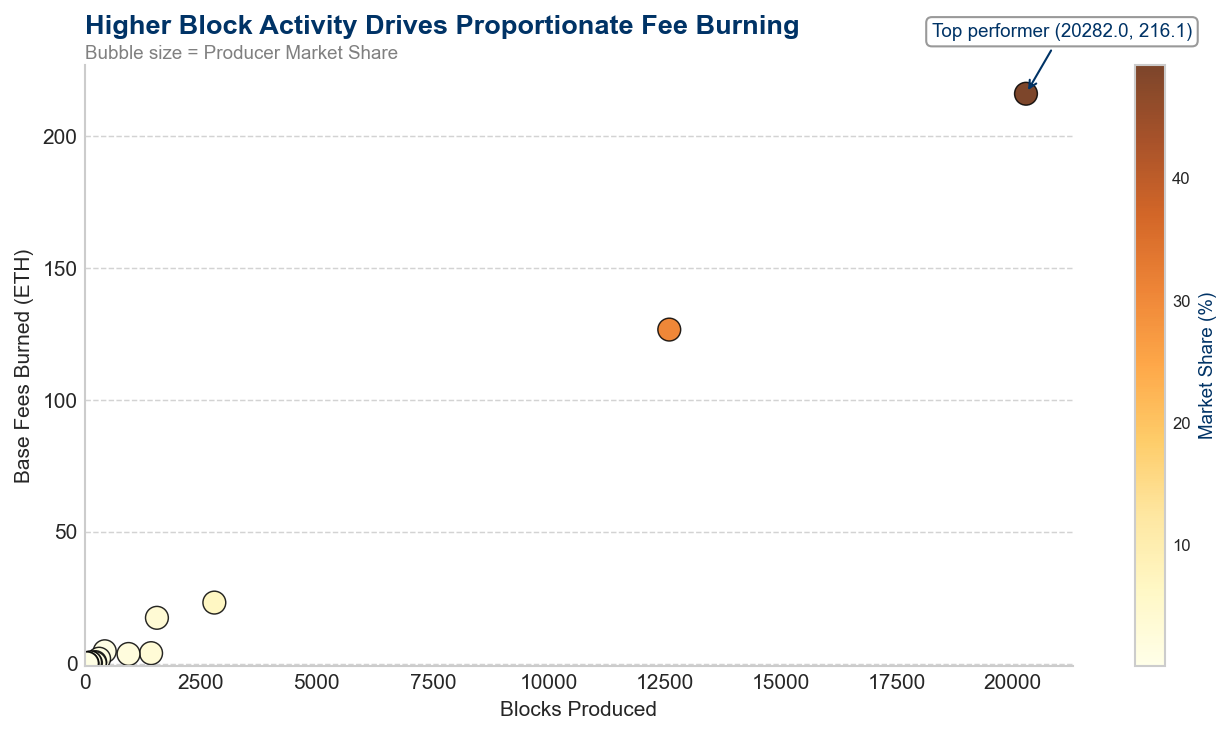

In [ ]:
if 'block_producers'in spark_dfs:
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(9, 5), dpi=150)
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    # --- Scatter plot ---
    sc = ax.scatter(df_producers["blocks_produced"], df_producers["base_fees_burned_eth"],
                    s=120, c=df_producers["market_share_pct"], cmap="YlOrBr",
                    edgecolors="black", linewidth=0.7, alpha=0.85)

    # --- Titles & Labels ---
    ax.set_title("Higher Block Activity Drives Proportionate Fee Burning",
                fontsize=13, fontweight="bold", color="#003366", loc="left", pad=15)
    ax.text(0, 1.01, "Bubble size = Producer Market Share",
            transform=ax.transAxes, fontsize=9, color="gray", ha="left")
    ax.set_xlabel("Blocks Produced", fontsize=10)
    ax.set_ylabel("Base Fees Burned (ETH)", fontsize=10)

    # --- Colorbar ---
    cbar = plt.colorbar(sc)
    cbar.set_label("Market Share (%)", fontsize=9, color="#003366")
    cbar.ax.tick_params(labelsize=8)

    # --- Annotation for standout performer ---
    key_idx = df_producers["base_fees_burned_eth"].idxmax()
    x_key = df_producers.loc[key_idx, "blocks_produced"]
    y_key = df_producers.loc[key_idx, "base_fees_burned_eth"]
    ax.annotate(f"Top performer ({x_key:.1f}, {y_key:.1f})", xy=(x_key, y_key),
                xytext=(x_key * 0.9, y_key * 1.1),
                fontsize=9, color="#003366",
                arrowprops=dict(arrowstyle="->", color="#003366", lw=1),
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8, edgecolor="gray"))

    # --- Cleanup ---
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, axis="y", linestyle="--", color="lightgray", lw=0.7)
    ax.grid(False, axis="x")
    ax.set_ylim(bottom=-1)
    ax.set_xlim(left=-1)

    plt.tight_layout()
    plt.savefig("block_fees_burning.png", dpi=300, bbox_inches="tight")
    plt.show()


## 11- Time Series Decomposition
### Trend, Seasonality, and Residual Analysis

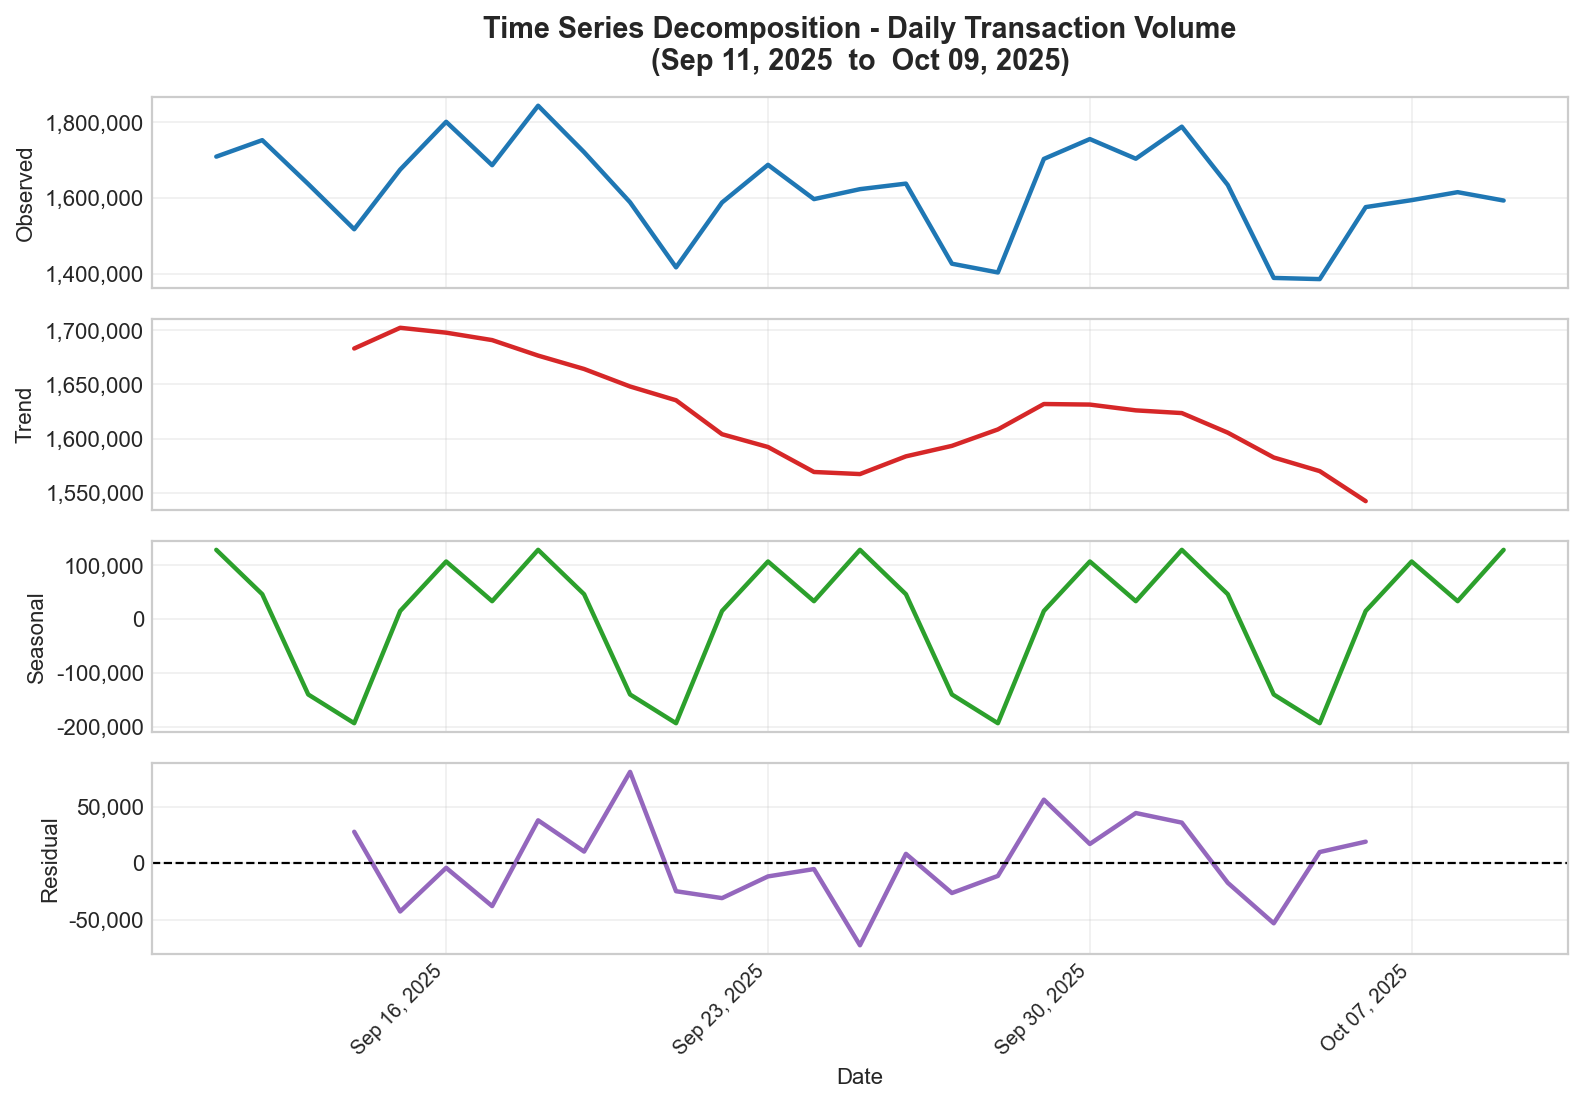

In [ ]:
if 'daily_activity' in spark_dfs and len(df_daily) > 14:
    # Prepare time series
    ts_data = (
        df_daily.set_index('date')['total_transactions']
        .asfreq('D')
        .interpolate('linear')
    )

    decomposition = seasonal_decompose(ts_data, model='additive', period=7)

    # --- decomposition ---
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, axes = plt.subplots(4, 1, figsize=(10, 7), dpi=160, sharex=True)
    fig.patch.set_facecolor("white")

    components = [
        ("Observed", decomposition.observed, "#1f77b4"),
        ("Trend", decomposition.trend, "#d62728"),
        ("Seasonal", decomposition.seasonal, "#2ca02c"),
        ("Residual", decomposition.resid, "#9467bd"),
    ]

    for i, (label, series, color) in enumerate(components):
        axes[i].plot(series, color=color, linewidth=2)
        axes[i].set_ylabel(label, fontsize=10)
        axes[i].grid(True, alpha=0.3)
        axes[i].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))
        if label == "Residual":
            axes[i].axhline(y=0, color="black", linestyle="--", linewidth=1)

    # --- Titles & Labels ---
    start_date = ts_data.index.min().strftime("%b %d, %Y")
    end_date = ts_data.index.max().strftime("%b %d, %Y")
    axes[0].set_title(
        f"Time Series Decomposition - Daily Transaction Volume\n({start_date}  to  {end_date})",
        fontsize=13,
        fontweight="bold",
        pad=12,
    )
    axes[-1].set_xlabel("Date", fontsize=10)

    # --- X-axis Date Formatting ---
    axes[-1].xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%b %d, %Y"))
    plt.setp(axes[-1].get_xticklabels(), rotation=45, ha="right", fontsize=9)

    plt.tight_layout()
    plt.savefig("time_decomposition_dated.png", dpi=300, bbox_inches="tight")
    plt.show()




## 12 - Correlation Analysis & Feature Engineering
### Multi-dimensional Relationship Discovery


🔗 Feature Correlation Analysis:

Strongest Positive Correlations:
  total_transactions <-> tx_per_block: 1.000
  avg_gas_used <-> avg_block_utilization_pct: 1.000
  avg_gas_price_gwei <-> total_fees_eth: 0.997
  total_transactions <-> total_data_mb: 0.944
  total_data_mb <-> tx_per_block: 0.940


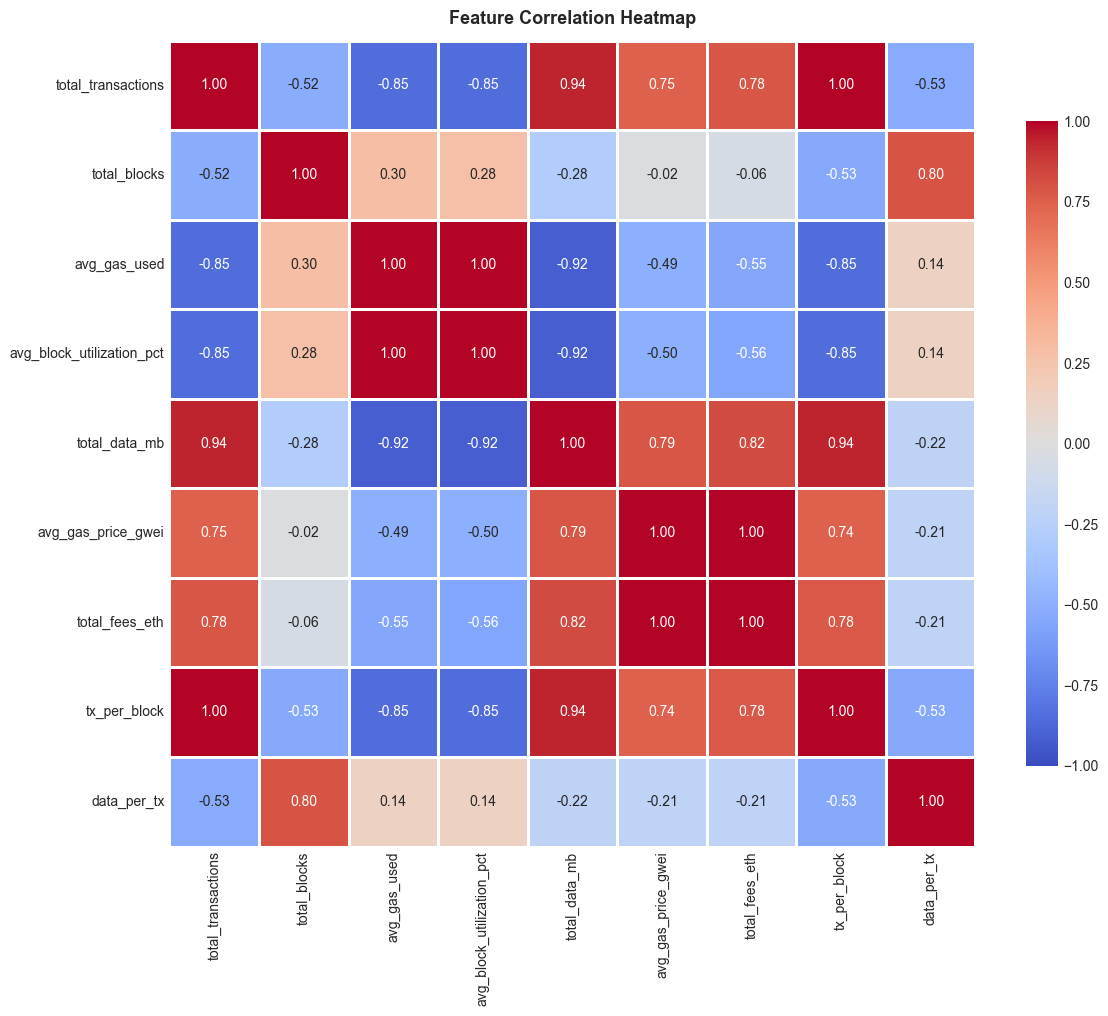

In [ ]:
# Create comprehensive feature matrix
if 'daily_activity' in spark_dfs and 'gas_analysis' in spark_dfs:
    # Merge datasets
    df_features = df_daily.merge(
        df_gas[['date', 'avg_gas_price_gwei', 'total_fees_eth']], 
        on='date', 
        how='inner'
    )
    
    # Engineer features
    df_features['tx_per_block'] = df_features['total_transactions'] / df_features['total_blocks']
    df_features['data_per_tx'] = df_features['total_data_mb'] / df_features['total_transactions'] * 1024  # KB
    df_features['gas_per_mb'] = df_features['avg_gas_used'] / (df_features['total_data_mb'] + 0.001)
    
    # Calculate correlation matrix
    feature_cols = ['total_transactions', 'total_blocks', 'avg_gas_used', 
                   'avg_block_utilization_pct', 'total_data_mb', 
                   'avg_gas_price_gwei', 'total_fees_eth', 
                   'tx_per_block', 'data_per_tx']
    
    corr_matrix = df_features[feature_cols].corr()
    
    print("\n🔗 Feature Correlation Analysis:")
    print("\nStrongest Positive Correlations:")
    corr_values = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_values.append((corr_matrix.columns[i], corr_matrix.columns[j], 
                              corr_matrix.iloc[i, j]))
    corr_values.sort(key=lambda x: abs(x[2]), reverse=True)
    for feat1, feat2, corr in corr_values[:5]:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")
    # save in json
    corr_summary = {
        "strongest_positive_correlations": [
            {"feature_1": feat1, "feature_2": feat2, "correlation": corr}
            for feat1, feat2, corr in corr_values[:5]
        ]
    }
    with open("feature_correlation_analysis.json", "w") as f:
        json.dump(corr_summary, f, indent=4)


# Correlation heatmap
if 'daily_activity' in spark_dfs and 'gas_analysis' in spark_dfs:
    fig, ax = plt.subplots(figsize=(12, 10))
    
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
                vmin=-1, vmax=1, ax=ax)
    
    ax.set_title('Feature Correlation Heatmap', fontsize=13, fontweight='bold', pad=12)
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
